In [1]:
from fun_clean import cleaning, cleaning_sub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

In [2]:
data = pd.read_csv('airbnb_data.csv')

In [3]:
data = cleaning(data)

In [4]:
data

,room_type,accommodates,bathrooms,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,zipcode,bedrooms,...,Chicago,DC,LA,NYC,SF,delta_first,delta_last,delta_host,verified,instant
0,1.000000,7,1.0,1.0,40.766115,-73.989040,6,93.0,10019,3.0,...,0,0,0,1,0,2.349196,2.215039,2.477878,0,1
2,1.000000,2,1.0,1.0,34.046737,-118.260439,9,93.0,90015,1.0,...,0,0,1,0,0,2.984390,2.664055,6.565573,1,0
4,0.413769,2,1.0,1.0,40.723883,-73.983880,82,93.0,10009,1.0,...,0,0,0,1,0,6.620331,3.069266,6.707944,1,0
5,0.413769,2,2.0,1.0,42.339194,-71.049672,12,88.0,2127,1.0,...,0,0,0,0,0,3.403290,2.839281,5.374583,1,0
6,1.000000,8,1.0,1.0,40.643773,-73.950855,5,72.0,11226,3.0,...,0,0,0,1,0,2.365624,2.236942,2.590132,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28871,1.000000,4,1.0,1.0,38.921312,-77.028127,19,91.0,20009,1.0,...,0,1,0,0,0,5.103531,3.113072,5.125434,1,0
28872,0.413769,2,1.0,1.0,40.740904,-74.002948,31,92.0,10011,1.0,...,0,0,0,1,0,3.942658,3.553875,6.598428,1,1
28874,1.000000,2,1.0,1.0,37.789989,-122.407384,24,98.0,94108,1.0,...,0,0,0,0,1,8.002974,4.076815,8.208317,0,0
28875,1.000000,4,2.0,1.0,33.871549,-118.396053,16,93.0,90254,2.0,...,0,0,1,0,0,3.321153,2.655842,3.605895,0,0


In [5]:
mx_result = pd.DataFrame(columns = ['sme','rsme','mean','std','var']).T

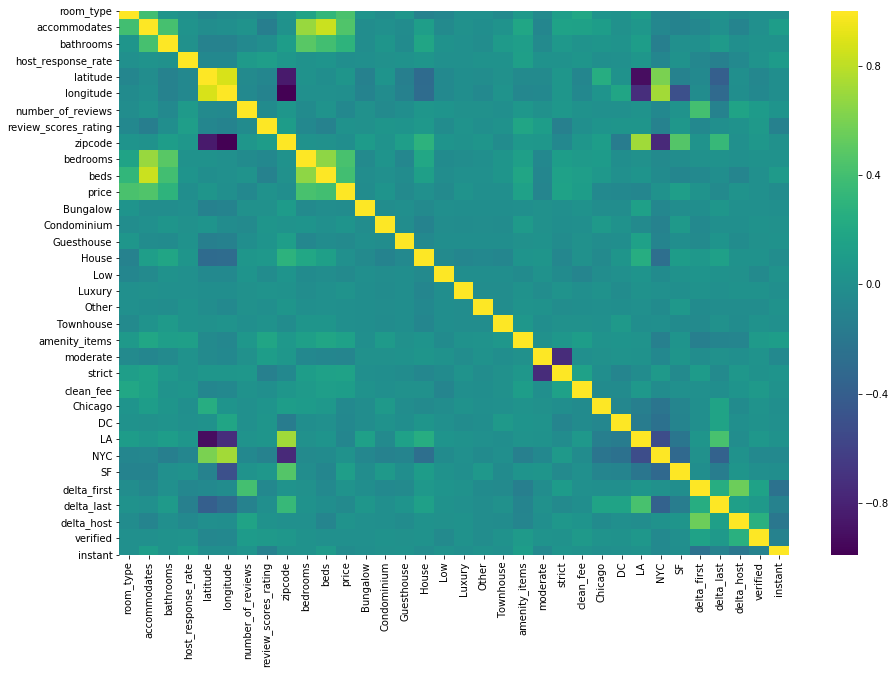

In [6]:
datacorr = data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(datacorr, cmap = 'viridis');

## Regresión Lineal - Elastic Net

Usando 33 columnas

In [7]:
X = data.drop(['price','zipcode','latitude','longitude'],axis = 1)
y = data.price

In [8]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [10]:
#elastic = ElasticNet().fit(X_train,y_train)
#y_pred_elastic = elastic.predict(X_test)

In [11]:
#mx_result['elastic_33'] = [mse(y_test, y_pred_elastic),mse(y_test,y_pred_elastic)**0.5]

Usando 5 columnas con alta correlación a price

In [12]:
X_pcorr = data[['accommodates','bathrooms','bedrooms','latitude']]

In [13]:
X_train_pcorr, X_test_pcorr = train_test_split(X_pcorr, test_size = 0.25)

In [14]:
elastic_pcorr = ElasticNet().fit(X_train_pcorr,y_train)
y_pred_elastic_pcorr = elastic_pcorr.predict(X_test_pcorr)

In [15]:
space={
    'alpha':hp.quniform('x_alpha', 1., 10., 1.),
}

In [16]:
def objetivo_elastic_pcorr(space):
    
    elastic_pcorr_opt=ElasticNet(
        alpha=space['alpha']
    )
    
    elastic_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_elastic_pcorr_opt=elastic_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_elastic_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [17]:
best_elastic_pcorr=fmin(fn=objetivo_elastic_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 203.23it/s, best loss: 64.06339193190641]


In [18]:
elastic_pcorr_opt = ElasticNet(
    alpha=best_elastic_pcorr['x_alpha']).fit(X_train_pcorr,y_train)
y_pred_elastic_pcorr_opt = elastic_pcorr_opt.predict(X_test_pcorr)

In [19]:
mx_result['elastic_5_pcorr_opt'] = [mse(y_test, y_pred_elastic_pcorr_opt),mse(y_test,y_pred_elastic_pcorr_opt)**0.5,y_pred_elastic_pcorr_opt.mean(),y_pred_elastic_pcorr_opt.std(),y_pred_elastic_pcorr_opt.var()]

Usando 11 columnas

In [20]:
X_feat = data[['bathrooms','bedrooms','number_of_reviews','review_scores_rating','Chicago','DC','LA','NYC','SF','delta_host']]

In [21]:
X_train_feat, X_test_feat = train_test_split(X_feat, test_size = 0.25)

In [22]:
elastic_feat = ElasticNet().fit(X_train_feat,y_train)
y_pred_elastic_feat = elastic_feat.predict(X_test_feat)

In [23]:
def objetivo_elastic_feat(space):
    
    elastic_feat_opt=ElasticNet(
        alpha=space['alpha']
    )
    
    elastic_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_elastic_feat_opt=elastic_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_elastic_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [24]:
best_elastic_feat=fmin(fn=objetivo_elastic_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 199.36it/s, best loss: 64.07552186820463]


In [25]:
elastic_feat_opt = ElasticNet(
    alpha=best_elastic_feat['x_alpha']).fit(X_train_feat,y_train)
y_pred_elastic_feat_opt = elastic_feat_opt.predict(X_test_feat)

In [26]:
mx_result['elastic_11_feat_opt'] = [mse(y_test, y_pred_elastic_feat_opt),mse(y_test,y_pred_elastic_feat_opt)**0.5,y_pred_elastic_feat_opt.mean(),y_pred_elastic_feat_opt.std(),y_pred_elastic_feat_opt.var()]

7 columnas

In [27]:
X_num = data[['accommodates','bathrooms','latitude','number_of_reviews','review_scores_rating','bedrooms','beds']]

In [28]:
X_train_num, X_test_num = train_test_split(X_num, test_size = 0.25)

In [29]:
elastic_num = ElasticNet().fit(X_train_num,y_train)
y_pred_elastic_num = elastic_num.predict(X_test_num)

In [30]:
def objetivo_elastic_num(space):
    
    elastic_num_opt=ElasticNet(
        alpha=space['alpha']
    )
    
    elastic_num_opt.fit(X_train_num, y_train)
    
    y_pred_elastic_num_opt=elastic_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_elastic_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [31]:
best_elastic_num=fmin(fn=objetivo_elastic_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 219.18it/s, best loss: 64.06575219063609]


In [32]:
elastic_num_opt = ElasticNet(
    alpha=best_elastic_num['x_alpha']).fit(X_train_num,y_train)
y_pred_elastic_num_opt = elastic_num_opt.predict(X_test_num)

In [33]:
y_pred_elastic_num_opt

array([148.63694309, 148.6468347 , 148.62045706, ..., 148.54791852,
       148.43581352, 148.63364588])

In [34]:
mx_result['elastic_7_num_opt'] = [mse(y_test, y_pred_elastic_num_opt),mse(y_test,y_pred_elastic_num_opt)**0.5,y_pred_elastic_num_opt.mean(),y_pred_elastic_num_opt.std(),y_pred_elastic_num_opt.var()]

12 columnas

In [35]:
X_ubi = data[['delta_host','bathrooms','beds','Bungalow','Condominium','Guesthouse','House','Low','Luxury','Other','Townhouse','review_scores_rating']]

In [36]:
X_train_ubi, X_test_ubi = train_test_split(X_ubi, test_size = 0.25)

In [37]:
elastic_ubi = ElasticNet().fit(X_train_ubi,y_train)
y_pred_elastic_ubi = elastic_ubi.predict(X_test_ubi)

In [38]:
def objetivo_elastic_ubi(space):
    
    elastic_ubi_opt=ElasticNet(
        alpha=space['alpha']
    )
    
    elastic_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_elastic_ubi_opt=elastic_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_elastic_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [39]:
best_elastic_ubi=fmin(fn=objetivo_elastic_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 205.24it/s, best loss: 64.0630259186415]


In [40]:
elastic_ubi_opt = ElasticNet(
    alpha=best_elastic_ubi['x_alpha']).fit(X_train_ubi,y_train)
y_pred_elastic_ubi_opt = elastic_ubi_opt.predict(X_test_ubi)

In [41]:
mx_result['elastic_12_ubi_opt'] = [mse(y_test, y_pred_elastic_ubi_opt),mse(y_test,y_pred_elastic_ubi_opt)**0.5,y_pred_elastic_ubi_opt.mean(),y_pred_elastic_ubi_opt.std(),y_pred_elastic_ubi_opt.var()]

## SVR

33 columnas

In [42]:
import warnings
warnings.simplefilter('ignore')

from sklearn.svm import SVR

In [43]:
#svr = SVR().fit(X_train,y_train)
#y_pred_svr = svr.predict(X_test)

In [44]:
space={
    'C':hp.quniform('x_C', 1, 15, 1),
    'epsilon':hp.uniform('x_epsilon', 0.1, 1.0),
    'coef0':hp.quniform('x_coef0', 0.5, 5.0, 0.5),
    'degree':hp.quniform('x_degree', 4, 20, 4),
}

In [45]:
def objetivo_svr_opt(space):
    
    svr_opt=SVR(
        C=space['C'],
        epsilon=space['epsilon'],
        coef0=space['coef0'],
        degree=int(space['degree'])
    )
    
    svr_opt.fit(X_train, y_train)
    
    y_pred_opt=svr_opt.predict(X_test)
    
    rmse=mse(y_test, y_pred_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [46]:
#best_svr=fmin(fn=objetivo_svr_opt, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

In [47]:
#svr_33_opt = SVR(
    #C=best_svr['x_C'],
    #epsilon=best_svr['x_epsilon'],
    #coef0=best_svr['x_coef0'],
    #degree=best_svr['x_degree']).fit(X_train,y_train)
#y_pred_svr_33_opt = svr_33_opt.predict(X_test)

In [48]:
#mx_result['svr_33_opt'] = [mse(y_test, y_pred_svr_33_opt),mse(y_test,y_pred_svr_33_opt)**0.5,y_pred_svr_33_opt.mean(),y_pred_svr_33_opt.std(),y_pred_svr_33_opt.var()]

5 columnas

In [49]:
#svr_pcorr = SVR().fit(X_train_pcorr,y_train)
#y_pred_svr_pcorr = svr_pcorr.predict(X_test_pcorr)

In [50]:
#mx_result['svr_5_pcorr'] = [mse(y_test, y_pred_svr_pcorr),mse(y_test,y_pred_svr_pcorr)**0.5]

11 columnas

In [51]:
#svr_feat = SVR().fit(X_train_feat,y_train)
#y_pred_svr_feat = svr_feat.predict(X_test_feat)

In [52]:
#mx_result['svr_11_feat'] = [mse(y_test, y_pred_svr_feat),mse(y_test,y_pred_svr_feat)**0.5]

7 columnas

In [53]:
#svr_num = SVR().fit(X_train_num,y_train)
#y_pred_svr_num = svr_num.predict(X_test_num)

In [54]:
#mx_result['svr_7_num'] = [mse(y_test, y_pred_svr_num),mse(y_test,y_pred_svr_num)**0.5]

12 columnas

In [55]:
#svr_ubi = SVR().fit(X_train_ubi,y_train)
#y_pred_svr_ubi = svr_ubi.predict(X_test_ubi)

In [56]:
#mx_result['svr_12_ubi'] = [mse(y_test, y_pred_svr_ubi),mse(y_test,y_pred_svr_ubi)**0.5]

## Random Forest Regression

33 columnas

In [57]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [58]:
#rfr = RFR().fit(X_train,y_train)
#y_pred_rfr = rfr.predict(X_test)

In [59]:
#mx_result['rfr_33'] = [mse(y_test, y_pred_rfr),mse(y_test,y_pred_rfr)**0.5]

5 columnas

In [60]:
rfr_pcorr = RFR().fit(X_train_pcorr,y_train)
y_pred_rfr_pcorr = rfr_pcorr.predict(X_test_pcorr)

In [61]:
space={
    'min_samples_leaf':hp.uniform('x_min_samples_leaf', 0.1, 0.5),
    'min_samples_split':hp.quniform('x_min_samples_split', 2, 10, 2),
    'min_weight_fraction_leaf':hp.uniform('x_min_weight_fraction_leaf', 0.1, 0.5),
    'n_estimators':hp.quniform('x_n_estimators', 10, 50, 5)
}

In [62]:
def objetivo_rfr_pcorr(space):
    
    rfr_pcorr_opt=RFR(
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators'])
    )
    
    rfr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_rfr_pcorr_opt=rfr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_rfr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [63]:
best_rfr_pcorr=fmin(fn=objetivo_rfr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 16.91it/s, best loss: 64.04785879780746]


In [64]:
rfr_pcorr_opt = RFR(
    min_samples_leaf=best_rfr_pcorr['x_min_samples_leaf'],
    min_samples_split=int(best_rfr_pcorr['x_min_samples_split']),
    min_weight_fraction_leaf=best_rfr_pcorr['x_min_weight_fraction_leaf'],
    n_estimators=int(best_rfr_pcorr['x_n_estimators'])).fit(X_train_pcorr,y_train)
y_pred_rfr_pcorr_opt = rfr_pcorr_opt.predict(X_test_pcorr)

In [65]:
mx_result['rfr_5_pcorr_opt'] = [mse(y_test, y_pred_rfr_pcorr_opt),mse(y_test,y_pred_rfr_pcorr_opt)**0.5,y_pred_rfr_pcorr_opt.mean(),y_pred_rfr_pcorr_opt.std(),y_pred_rfr_pcorr_opt.var()]

11 columnas

In [66]:
rfr_feat = RFR().fit(X_train_feat,y_train)
y_pred_rfr_feat = rfr_feat.predict(X_test_feat)

In [67]:
def objetivo_rfr_feat(space):
    
    rfr_feat_opt=RFR(
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators'])
    )
    
    rfr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_rfr_feat_opt=rfr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_rfr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [68]:
best_rfr_feat=fmin(fn=objetivo_rfr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 18.71it/s, best loss: 64.06329258773816]


In [69]:
rfr_feat_opt = RFR(
    min_samples_leaf=best_rfr_feat['x_min_samples_leaf'],
    min_samples_split=int(best_rfr_feat['x_min_samples_split']),
    min_weight_fraction_leaf=best_rfr_feat['x_min_weight_fraction_leaf'],
    n_estimators=int(best_rfr_feat['x_n_estimators'])).fit(X_train_feat,y_train)
y_pred_rfr_feat_opt = rfr_feat_opt.predict(X_test_feat)

In [70]:
mx_result['rfr_11_feat_opt'] = [mse(y_test, y_pred_rfr_feat_opt),mse(y_test,y_pred_rfr_feat_opt)**0.5,y_pred_rfr_feat_opt.mean(),y_pred_rfr_feat_opt.std(),y_pred_rfr_feat_opt.var()]

7 columnas

In [71]:
rfr_num = RFR().fit(X_train_num,y_train)
y_pred_rfr_num = rfr_num.predict(X_test_num)

In [72]:
def objetivo_rfr_num(space):
    
    rfr_num_opt=RFR(
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators'])
    )
    
    rfr_num_opt.fit(X_train_num, y_train)
    
    y_pred_rfr_num_opt=rfr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_rfr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [73]:
best_rfr_num=fmin(fn=objetivo_rfr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 19.11it/s, best loss: 64.06080448809494]


In [74]:
rfr_num_opt = RFR(
    min_samples_leaf=best_rfr_num['x_min_samples_leaf'],
    min_samples_split=int(best_rfr_num['x_min_samples_split']),
    min_weight_fraction_leaf=best_rfr_num['x_min_weight_fraction_leaf'],
    n_estimators=int(best_rfr_num['x_n_estimators'])).fit(X_train_num,y_train)
y_pred_rfr_num_opt = rfr_num_opt.predict(X_test_num)

In [75]:
mx_result['rfr_7_num_opt'] = [mse(y_test, y_pred_rfr_num_opt),mse(y_test,y_pred_rfr_num_opt)**0.5,y_pred_rfr_num_opt.mean(),y_pred_rfr_num_opt.std(),y_pred_rfr_num_opt.var()]

12 columnas

In [76]:
rfr_ubi = RFR().fit(X_train_ubi,y_train)
y_pred_rfr_ubi = rfr_ubi.predict(X_test_ubi)

In [77]:
def objetivo_rfr_ubi(space):
    
    rfr_ubi_opt=RFR(
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators'])
    )
    
    rfr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_rfr_ubi_opt=rfr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_rfr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [78]:
best_rfr_ubi=fmin(fn=objetivo_rfr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 21.05it/s, best loss: 64.06315082624711]


In [79]:
rfr_ubi_opt = RFR(
    min_samples_leaf=best_rfr_ubi['x_min_samples_leaf'],
    min_samples_split=int(best_rfr_ubi['x_min_samples_split']),
    min_weight_fraction_leaf=best_rfr_ubi['x_min_weight_fraction_leaf'],
    n_estimators=int(best_rfr_ubi['x_n_estimators'])).fit(X_train_ubi,y_train)
y_pred_rfr_ubi_opt = rfr_ubi_opt.predict(X_test_ubi)

In [80]:
mx_result['rfr_12_ubi_opt'] = [mse(y_test, y_pred_rfr_ubi_opt),mse(y_test,y_pred_rfr_ubi_opt)**0.5,y_pred_rfr_ubi_opt.mean(),y_pred_rfr_ubi_opt.std(),y_pred_rfr_ubi_opt.var()]

## KNN

33 columnas

In [81]:
from sklearn.neighbors import KNeighborsRegressor as KNNR

In [82]:
#knnr = KNNR().fit(X_train,y_train)
#y_pred_knnr = knnr.predict(X_test)

In [83]:
#mx_result['knnr_33'] = [mse(y_test, y_pred_knnr),mse(y_test,y_pred_knnr)**0.5]

5 columnas

In [84]:
knnr_pcorr = KNNR().fit(X_train_pcorr,y_train)
y_pred_knnr_pcorr = knnr_pcorr.predict(X_test_pcorr)

In [85]:
space={
    'leaf_size':hp.quniform('x_leaf_size', 10, 100, 5),
    'n_neighbors':hp.quniform('x_n_neighbors', 5, 50, 5),
    'p':hp.quniform('x_p', 2, 20, 2),
}

In [86]:
def objetivo_knnr_pcorr(space):
    
    knnr_pcorr_opt=KNNR(
        leaf_size=space['leaf_size'],
        n_neighbors=int(space['n_neighbors']),
        p=space['p'],
    )
    
    knnr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_knnr_pcorr_opt=knnr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_knnr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [87]:
best_knnr_pcorr=fmin(fn=objetivo_knnr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:01<00:00,  5.24it/s, best loss: 65.01754056301938]


In [88]:
knnr_pcorr_opt = KNNR(
    leaf_size=best_knnr_pcorr['x_leaf_size'],
    n_neighbors=int(best_knnr_pcorr['x_n_neighbors']),
    p=best_knnr_pcorr['x_p']).fit(X_train_pcorr,y_train)
y_pred_knnr_pcorr_opt = knnr_pcorr_opt.predict(X_test_pcorr)

In [89]:
mx_result['knnr_5_pcorr_opt'] = [mse(y_test, y_pred_knnr_pcorr_opt),mse(y_test,y_pred_knnr_pcorr_opt)**0.5,y_pred_knnr_pcorr_opt.mean(),y_pred_knnr_pcorr_opt.std(),y_pred_knnr_pcorr_opt.var()]

11 columnas

In [90]:
knnr_feat = KNNR().fit(X_train_feat,y_train)
y_pred_knnr_feat = knnr_feat.predict(X_test_feat)

In [91]:
def objetivo_knnr_feat(space):
    
    knnr_feat_opt=KNNR(
        leaf_size=space['leaf_size'],
        n_neighbors=int(space['n_neighbors']),
        p=space['p'],
    )
    
    knnr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_knnr_feat_opt=knnr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_knnr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [92]:
best_knnr_feat=fmin(fn=objetivo_knnr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:02<00:00,  4.56it/s, best loss: 64.86499445418444]


In [93]:
knnr_feat_opt = KNNR(
    leaf_size=best_knnr_feat['x_leaf_size'],
    n_neighbors=int(best_knnr_feat['x_n_neighbors']),
    p=best_knnr_feat['x_p']).fit(X_train_feat,y_train)
y_pred_knnr_feat_opt = knnr_feat_opt.predict(X_test_feat)

In [94]:
mx_result['knnr_11_feat_opt'] = [mse(y_test, y_pred_knnr_feat_opt),mse(y_test,y_pred_knnr_feat_opt)**0.5,y_pred_knnr_feat_opt.mean(),y_pred_knnr_feat_opt.std(),y_pred_knnr_feat_opt.var()]

7 columnas

In [95]:
knnr_num = KNNR().fit(X_train_num,y_train)
y_pred_knnr_num = knnr_num.predict(X_test_num)

In [96]:
def objetivo_knnr_num(space):
    
    knnr_num_opt=KNNR(
        leaf_size=space['leaf_size'],
        n_neighbors=int(space['n_neighbors']),
        p=space['p'],
    )
    
    knnr_num_opt.fit(X_train_num, y_train)
    
    y_pred_knnr_num_opt=knnr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_knnr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [97]:
best_knnr_num=fmin(fn=objetivo_knnr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:02<00:00,  4.41it/s, best loss: 64.62176426617161]


In [98]:
knnr_num_opt = KNNR(
    leaf_size=best_knnr_num['x_leaf_size'],
    n_neighbors=int(best_knnr_num['x_n_neighbors']),
    p=best_knnr_num['x_p']).fit(X_train_num,y_train)
y_pred_knnr_num_opt = knnr_num_opt.predict(X_test_num)

In [99]:
mx_result['knnr_7_num_opt'] = [mse(y_test, y_pred_knnr_num_opt),mse(y_test,y_pred_knnr_num_opt)**0.5,y_pred_knnr_num_opt.mean(),y_pred_knnr_num_opt.std(),y_pred_knnr_num_opt.var()]

12 columnas

In [100]:
knnr_ubi = KNNR().fit(X_train_ubi,y_train)
y_pred_knnr_ubi = knnr_ubi.predict(X_test_ubi)

In [101]:
def objetivo_knnr_ubi(space):
    
    knnr_ubi_opt=KNNR(
        leaf_size=space['leaf_size'],
        n_neighbors=int(space['n_neighbors']),
        p=space['p'],
    )
    
    knnr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_knnr_ubi_opt=knnr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_knnr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [102]:
best_knnr_ubi=fmin(fn=objetivo_knnr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:02<00:00,  3.88it/s, best loss: 64.77628286981687]


In [103]:
knnr_ubi_opt = KNNR(
    leaf_size=best_knnr_ubi['x_leaf_size'],
    n_neighbors=int(best_knnr_ubi['x_n_neighbors']),
    p=best_knnr_ubi['x_p']).fit(X_train_ubi,y_train)
y_pred_knnr_ubi_opt = knnr_ubi_opt.predict(X_test_ubi)

In [104]:
mx_result['knnr_12_ubi_opt'] = [mse(y_test, y_pred_knnr_ubi_opt),mse(y_test,y_pred_knnr_ubi_opt)**0.5,y_pred_knnr_ubi_opt.mean(),y_pred_knnr_ubi_opt.std(),y_pred_knnr_ubi_opt.var()]

## Grad Boost Regressor

33 columnas

In [105]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [106]:
#gbr = GBR().fit(X_train,y_train)
#y_pred_gbr = gbr.predict(X_test)

In [107]:
#mx_result['gbr_33'] = [mse(y_test, y_pred_gbr),mse(y_test,y_pred_gbr)**0.5]

5 columnas

In [108]:
gbr_pcorr = GBR().fit(X_train_pcorr,y_train)
y_pred_gbr_pcorr = gbr_pcorr.predict(X_test_pcorr)

In [109]:
space={
    'alpha':hp.uniform('x_alpha', 0.1, 1.0),
    'learning_rate':hp.uniform('x_learning_rate', 0.1, 10.0),
    'max_depth':hp.quniform('x_max_depth', 1, 15, 1),
    'min_impurity_decrease':hp.uniform('x_min_impurity_decrease',0.0, 5.0),
    'min_samples_leaf':hp.uniform('x_min_samples_leaf', 1, 10),
    'min_samples_split':hp.quniform('x_min_samples_split', 2, 10, 2),
    'min_weight_fraction_leaf':hp.uniform('x_min_weight_fraction_leaf', 0.1, 0.5),
    'n_estimators':hp.quniform('x_n_estimators', 50, 150, 5),
    'subsample':hp.uniform('x_subsample', 0.1, 1.0),
    'tol':hp.uniform('x_tol',0.001, 0.1),
    'validation_fraction':hp.uniform('x_validation_fraction', 0.1, 1.0)
}

In [110]:
def objetivo_gbr_pcorr(space):
    
    gbr_pcorr_opt=GBR(
        alpha=space['alpha'],
        learning_rate=space['learning_rate'],
        max_depth=space['max_depth'],
        min_impurity_decrease=space['min_impurity_decrease'],
        min_samples_leaf=int(space['min_samples_leaf']),
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction']
    )
    
    gbr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_gbr_pcorr_opt=gbr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_gbr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [111]:
best_gbr_pcorr=fmin(fn=objetivo_gbr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:01<00:00,  6.25it/s, best loss: 64.11189949748615]   


In [112]:
gbr_pcorr_opt = GBR(
    alpha=best_gbr_pcorr['x_alpha'],
    learning_rate=best_gbr_pcorr['x_learning_rate'],
    max_depth=best_gbr_pcorr['x_max_depth'],
    min_impurity_decrease=best_gbr_pcorr['x_min_impurity_decrease'],
    min_samples_leaf=int(best_gbr_pcorr['x_min_samples_leaf']),
    min_samples_split=int(best_gbr_pcorr['x_min_samples_split']),
    min_weight_fraction_leaf=best_gbr_pcorr['x_min_weight_fraction_leaf'],
    subsample=best_gbr_pcorr['x_subsample'],
    tol=best_gbr_pcorr['x_tol'],
    validation_fraction=best_gbr_pcorr['x_validation_fraction']).fit(X_train_pcorr,y_train)
y_pred_gbr_pcorr_opt = gbr_pcorr_opt.predict(X_test_pcorr)

In [113]:
mx_result['gbr_5_pcorr_opt'] = [mse(y_test, y_pred_gbr_pcorr_opt),mse(y_test,y_pred_gbr_pcorr_opt)**0.5,y_pred_gbr_pcorr_opt.mean(),y_pred_gbr_pcorr_opt.std(),y_pred_gbr_pcorr_opt.var()]

11 columnas

In [114]:
gbr_feat = GBR().fit(X_train_feat,y_train)
y_pred_gbr_feat = gbr_feat.predict(X_test_feat)

In [115]:
def objetivo_gbr_feat(space):
    
    gbr_feat_opt=GBR(
        alpha=space['alpha'],
        learning_rate=space['learning_rate'],
        max_depth=space['max_depth'],
        min_impurity_decrease=space['min_impurity_decrease'],
        min_samples_leaf=int(space['min_samples_leaf']),
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction']
    )
    
    gbr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_gbr_feat_opt=gbr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_gbr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [116]:
best_gbr_feat=fmin(fn=objetivo_gbr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:02<00:00,  4.23it/s, best loss: 1.599292081816796e+46]


In [117]:
gbr_feat_opt = GBR(
    alpha=best_gbr_feat['x_alpha'],
    learning_rate=best_gbr_feat['x_learning_rate'],
    max_depth=best_gbr_feat['x_max_depth'],
    min_impurity_decrease=best_gbr_feat['x_min_impurity_decrease'],
    min_samples_leaf=int(best_gbr_feat['x_min_samples_leaf']),
    min_samples_split=int(best_gbr_feat['x_min_samples_split']),
    min_weight_fraction_leaf=best_gbr_feat['x_min_weight_fraction_leaf'],
    subsample=best_gbr_feat['x_subsample'],
    tol=best_gbr_feat['x_tol'],
    validation_fraction=best_gbr_feat['x_validation_fraction']).fit(X_train_feat,y_train)
y_pred_gbr_feat_opt = gbr_feat_opt.predict(X_test_feat)

In [118]:
mx_result['gbr_11_feat_opt'] = [mse(y_test, y_pred_gbr_feat_opt),mse(y_test,y_pred_gbr_feat_opt)**0.5,y_pred_gbr_feat_opt.mean(),y_pred_gbr_feat_opt.std(),y_pred_gbr_feat_opt.var()]

7 columnas

In [119]:
gbr_num = GBR().fit(X_train_num,y_train)
y_pred_gbr_num = gbr_num.predict(X_test_num)

In [120]:
def objetivo_gbr_num(space):
    
    gbr_num_opt=GBR(
        alpha=space['alpha'],
        learning_rate=space['learning_rate'],
        max_depth=space['max_depth'],
        min_impurity_decrease=space['min_impurity_decrease'],
        min_samples_leaf=int(space['min_samples_leaf']),
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction']
    )
    
    gbr_num_opt.fit(X_train_num, y_train)
    
    y_pred_gbr_num_opt=gbr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_gbr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [121]:
best_gbr_num=fmin(fn=objetivo_gbr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:02<00:00,  4.31it/s, best loss: 64.1215848237334]      


In [122]:
gbr_num_opt = GBR(
    alpha=best_gbr_num['x_alpha'],
    learning_rate=best_gbr_num['x_learning_rate'],
    max_depth=best_gbr_num['x_max_depth'],
    min_impurity_decrease=best_gbr_num['x_min_impurity_decrease'],
    min_samples_leaf=int(best_gbr_num['x_min_samples_leaf']),
    min_samples_split=int(best_gbr_num['x_min_samples_split']),
    min_weight_fraction_leaf=best_gbr_num['x_min_weight_fraction_leaf'],
    subsample=best_gbr_num['x_subsample'],
    tol=best_gbr_num['x_tol'],
    validation_fraction=best_gbr_num['x_validation_fraction']).fit(X_train_num,y_train)
y_pred_gbr_num_opt = gbr_num_opt.predict(X_test_num)

In [123]:
mx_result['gbr_7_num_opt'] = [mse(y_test, y_pred_gbr_num_opt),mse(y_test,y_pred_gbr_num_opt)**0.5,y_pred_gbr_num_opt.mean(),y_pred_gbr_num_opt.std(),y_pred_gbr_num_opt.var()]

12 columnas

In [124]:
gbr_ubi = GBR().fit(X_train_ubi,y_train)
y_pred_gbr_ubi = gbr_ubi.predict(X_test_ubi)

In [125]:
def objetivo_gbr_ubi(space):
    
    gbr_ubi_opt=GBR(
        alpha=space['alpha'],
        learning_rate=space['learning_rate'],
        max_depth=space['max_depth'],
        min_impurity_decrease=space['min_impurity_decrease'],
        min_samples_leaf=int(space['min_samples_leaf']),
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction']
    )
    
    gbr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_gbr_ubi_opt=gbr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_gbr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [126]:
best_gbr_ubi=fmin(fn=objetivo_gbr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:02<00:00,  4.09it/s, best loss: 64.12677210621592]


In [127]:
gbr_ubi_opt = GBR(
    alpha=best_gbr_ubi['x_alpha'],
    learning_rate=best_gbr_ubi['x_learning_rate'],
    max_depth=best_gbr_ubi['x_max_depth'],
    min_impurity_decrease=best_gbr_ubi['x_min_impurity_decrease'],
    min_samples_leaf=int(best_gbr_ubi['x_min_samples_leaf']),
    min_samples_split=int(best_gbr_ubi['x_min_samples_split']),
    min_weight_fraction_leaf=best_gbr_ubi['x_min_weight_fraction_leaf'],
    subsample=best_gbr_ubi['x_subsample'],
    tol=best_gbr_ubi['x_tol'],
    validation_fraction=best_gbr_ubi['x_validation_fraction']).fit(X_train_ubi,y_train)
y_pred_gbr_ubi_opt = gbr_ubi_opt.predict(X_test_ubi)

In [128]:
mx_result['gbr_12_ubi_opt'] = [mse(y_test, y_pred_gbr_ubi_opt),mse(y_test,y_pred_gbr_ubi_opt)**0.5,y_pred_gbr_ubi_opt.mean(),y_pred_gbr_ubi_opt.std(),y_pred_gbr_ubi_opt.var()]

## XGBoost

33 columnas

In [129]:
from xgboost import XGBRegressor as XGBR

In [130]:
#xgbr = XGBR().fit(X_train,y_train)
#y_pred_xgbr = xgbr.predict(X_test)

In [131]:
#mx_result['xgbr_33'] = [mse(y_test, y_pred_xgbr),mse(y_test,y_pred_xgbr)**0.5]

5 columnas

In [132]:
xgbr_pcorr = XGBR().fit(X_train_pcorr,y_train)
y_pred_xgbr_pcorr = xgbr_pcorr.predict(X_test_pcorr)

[00:38:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [133]:
space={
    'base_score':hp.uniform('x_base_score', 0.5, 5.0),
    'colsample_bylevel':hp.uniform('x_colsample_bylevel',0.1,1),
    'colsample_bynode':hp.uniform('x_colsample_bynode',0.1,1),
    'colsample_bytree':hp.uniform('x_colsample_bytree',0.1,1),
    'gamma':hp.quniform('x_gamma',0,10,1),
    'learning_rate':hp.uniform('x_learning_rate', 0.1, 10.0),
    'max_delta_step':hp.quniform('x_max_delta_step',1,15,1),
    'max_depth':hp.quniform('x_max_depth', 1, 15, 1),
    'min_child_weight':hp.quniform('x_min_child_weight',1,15,1),
    'n_estimators':hp.quniform('x_n_estimators', 50, 150, 5),
    'random_state':hp.uniform('x_random_state',0.1,1),
    'reg_alpha':hp.quniform('x_reg_alpha',1,15,1),
    'subsample':hp.uniform('x_subsample', 0.1, 1.0),
    'reg_lambda':hp.quniform('x_reg_lambda',1,15,1),
    'scale_pos_weight':hp.quniform('x_scale_pos_weight', 1,15,1),
}

In [134]:
def objetivo_xgbr_pcorr(space):
    
    xgbr_pcorr_opt=XGBR(
        base_score=space['base_score'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        learning_rate=space['learning_rate'],
        max_delta_step=space['max_delta_step'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        n_estimators=int(space['n_estimators']),
        random_state=int(space['random_state']),
        reg_alpha=space['reg_alpha'],
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
        scale_pos_weight=space['scale_pos_weight'],
    )
    
    xgbr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_xgbr_pcorr_opt=xgbr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_xgbr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [135]:
best_xgbr_pcorr=fmin(fn=objetivo_xgbr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

[00:38:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [136]:
xgbr_pcorr_opt = XGBR(
    base_score=best_xgbr_pcorr['x_base_score'],
    colsample_bylevel=best_xgbr_pcorr['x_colsample_bylevel'],
    colsample_bynode=best_xgbr_pcorr['x_colsample_bynode'],
    colsample_bytree=best_xgbr_pcorr['x_colsample_bytree'],
    gamma=best_xgbr_pcorr['x_gamma'],
    learning_rate=best_xgbr_pcorr['x_learning_rate'],
    max_delta_step=best_xgbr_pcorr['x_max_delta_step'],
    max_depth=int(best_xgbr_pcorr['x_max_depth']),
    min_child_weight=best_xgbr_pcorr['x_min_child_weight'],
    n_estimators=int(best_xgbr_pcorr['x_n_estimators']),
    random_state=int(best_xgbr_pcorr['x_random_state']),
    reg_alpha=best_xgbr_pcorr['x_reg_alpha'],
    subsample=best_xgbr_pcorr['x_subsample'],
    reg_lambda=best_xgbr_pcorr['x_reg_lambda'],
    scale_pos_weight=best_xgbr_pcorr['x_scale_pos_weight']).fit(X_train_pcorr,y_train)
y_pred_xgbr_pcorr_opt = xgbr_pcorr_opt.predict(X_test_pcorr)

[00:38:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [137]:
mx_result['xgbr_5_pcorr_opt'] = [mse(y_test, y_pred_xgbr_pcorr_opt),mse(y_test,y_pred_xgbr_pcorr_opt)**0.5,y_pred_xgbr_pcorr_opt.mean(),y_pred_xgbr_pcorr_opt.std(),y_pred_xgbr_pcorr_opt.var()]

11 columnas

In [138]:
xgbr_feat = XGBR().fit(X_train_feat,y_train)
y_pred_xgbr_feat = xgbr_feat.predict(X_test_feat)

[00:38:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [139]:
def objetivo_xgbr_feat(space):
    
    xgbr_feat_opt=XGBR(
        base_score=space['base_score'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        learning_rate=space['learning_rate'],
        max_delta_step=space['max_delta_step'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        n_estimators=int(space['n_estimators']),
        random_state=int(space['random_state']),
        reg_alpha=space['reg_alpha'],
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
        scale_pos_weight=space['scale_pos_weight'],
    )
    
    xgbr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_xgbr_feat_opt=xgbr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_xgbr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [140]:
best_xgbr_feat=fmin(fn=objetivo_xgbr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

[00:38:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [141]:
xgbr_feat_opt = XGBR(
    base_score=best_xgbr_feat['x_base_score'],
    colsample_bylevel=best_xgbr_feat['x_colsample_bylevel'],
    colsample_bynode=best_xgbr_feat['x_colsample_bynode'],
    colsample_bytree=best_xgbr_feat['x_colsample_bytree'],
    gamma=best_xgbr_feat['x_gamma'],
    learning_rate=best_xgbr_feat['x_learning_rate'],
    max_delta_step=best_xgbr_feat['x_max_delta_step'],
    max_depth=int(best_xgbr_feat['x_max_depth']),
    min_child_weight=best_xgbr_feat['x_min_child_weight'],
    n_estimators=int(best_xgbr_feat['x_n_estimators']),
    random_state=int(best_xgbr_feat['x_random_state']),
    reg_alpha=best_xgbr_feat['x_reg_alpha'],
    subsample=best_xgbr_feat['x_subsample'],
    reg_lambda=best_xgbr_feat['x_reg_lambda'],
    scale_pos_weight=best_xgbr_feat['x_scale_pos_weight']).fit(X_train_feat,y_train)
y_pred_xgbr_feat_opt = xgbr_feat_opt.predict(X_test_feat)

[00:38:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [142]:
mx_result['xgbr_11_feat_opt'] = [mse(y_test, y_pred_xgbr_feat_opt),mse(y_test,y_pred_xgbr_feat_opt)**0.5,y_pred_xgbr_feat_opt.mean(),y_pred_xgbr_feat_opt.std(),y_pred_xgbr_feat_opt.var()]

8 columnas

In [143]:
xgbr_num = XGBR().fit(X_train_num,y_train)
y_pred_xgbr_num = xgbr_num.predict(X_test_num)

[00:38:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [144]:
def objetivo_xgbr_num(space):
    
    xgbr_num_opt=XGBR(
        base_score=space['base_score'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        learning_rate=space['learning_rate'],
        max_delta_step=space['max_delta_step'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        n_estimators=int(space['n_estimators']),
        random_state=int(space['random_state']),
        reg_alpha=space['reg_alpha'],
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
        scale_pos_weight=space['scale_pos_weight'],
    )
    
    xgbr_num_opt.fit(X_train_num, y_train)
    
    y_pred_xgbr_num_opt=xgbr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_xgbr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [145]:
best_xgbr_num=fmin(fn=objetivo_xgbr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

[00:38:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [146]:
xgbr_num_opt = XGBR(
    base_score=best_xgbr_num['x_base_score'],
    colsample_bylevel=best_xgbr_num['x_colsample_bylevel'],
    colsample_bynode=best_xgbr_num['x_colsample_bynode'],
    colsample_bytree=best_xgbr_num['x_colsample_bytree'],
    gamma=best_xgbr_num['x_gamma'],
    learning_rate=best_xgbr_num['x_learning_rate'],
    max_delta_step=best_xgbr_num['x_max_delta_step'],
    max_depth=int(best_xgbr_num['x_max_depth']),
    min_child_weight=best_xgbr_num['x_min_child_weight'],
    n_estimators=int(best_xgbr_num['x_n_estimators']),
    random_state=int(best_xgbr_num['x_random_state']),
    reg_alpha=best_xgbr_num['x_reg_alpha'],
    subsample=best_xgbr_num['x_subsample'],
    reg_lambda=best_xgbr_num['x_reg_lambda'],
    scale_pos_weight=best_xgbr_num['x_scale_pos_weight']).fit(X_train_num,y_train)
y_pred_xgbr_num_opt = xgbr_num_opt.predict(X_test_num)

[00:38:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [147]:
mx_result['xgbr_8_num_opt'] = [mse(y_test, y_pred_xgbr_num_opt),mse(y_test,y_pred_xgbr_num_opt)**0.5,y_pred_xgbr_num_opt.mean(),y_pred_xgbr_num_opt.std(),y_pred_xgbr_num_opt.var()]

12 columnas

In [148]:
xgbr_ubi = XGBR().fit(X_train_ubi,y_train)
y_pred_xgbr_ubi = xgbr_ubi.predict(X_test_ubi)

[00:38:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [149]:
def objetivo_xgbr_ubi(space):
    
    xgbr_ubi_opt=XGBR(
        base_score=space['base_score'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        learning_rate=space['learning_rate'],
        max_delta_step=space['max_delta_step'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        n_estimators=int(space['n_estimators']),
        random_state=int(space['random_state']),
        reg_alpha=space['reg_alpha'],
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
        scale_pos_weight=space['scale_pos_weight'],
    )
    
    xgbr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_xgbr_ubi_opt=xgbr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_xgbr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [150]:
best_xgbr_ubi=fmin(fn=objetivo_xgbr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

[00:38:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [151]:
xgbr_ubi_opt = XGBR(
    base_score=best_xgbr_ubi['x_base_score'],
    colsample_bylevel=best_xgbr_ubi['x_colsample_bylevel'],
    colsample_bynode=best_xgbr_ubi['x_colsample_bynode'],
    colsample_bytree=best_xgbr_ubi['x_colsample_bytree'],
    gamma=best_xgbr_ubi['x_gamma'],
    learning_rate=best_xgbr_ubi['x_learning_rate'],
    max_delta_step=best_xgbr_ubi['x_max_delta_step'],
    max_depth=int(best_xgbr_ubi['x_max_depth']),
    min_child_weight=best_xgbr_ubi['x_min_child_weight'],
    n_estimators=int(best_xgbr_ubi['x_n_estimators']),
    random_state=int(best_xgbr_ubi['x_random_state']),
    reg_alpha=best_xgbr_ubi['x_reg_alpha'],
    subsample=best_xgbr_ubi['x_subsample'],
    reg_lambda=best_xgbr_ubi['x_reg_lambda'],
    scale_pos_weight=best_xgbr_ubi['x_scale_pos_weight']).fit(X_train_ubi,y_train)
y_pred_xgbr_ubi_opt = xgbr_ubi_opt.predict(X_test_ubi)

[00:38:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [152]:
mx_result['xgbr_12_ubi_opt'] = [mse(y_test, y_pred_xgbr_ubi_opt),mse(y_test,y_pred_xgbr_ubi_opt)**0.5,y_pred_xgbr_ubi_opt.mean(),y_pred_xgbr_ubi_opt.std(),y_pred_xgbr_ubi_opt.var()]

## SDGRegressor

33 columnas

In [153]:
from sklearn.linear_model import SGDRegressor as SGDR

In [154]:
#sgdr = SGDR().fit(X_train,y_train)
#y_pred_sgdr = sgdr.predict(X_test)

In [155]:
#mx_result['sgdr_33'] = [mse(y_test, y_pred_sgdr),mse(y_test,y_pred_sgdr)**0.5]

5 columnas

In [156]:
#sgdr_pcorr = SGDR().fit(X_train_pcorr,y_train)
#y_pred_sgdr_pcorr = sgdr_pcorr.predict(X_test_pcorr)

In [157]:
#mx_result['sgdr_5_pcorr'] = [mse(y_test, y_pred_sgdr_pcorr),mse(y_test,y_pred_sgdr_pcorr)**0.5]

11 columnas

In [158]:
#sgdr_feat = SGDR().fit(X_train_feat,y_train)
#y_pred_sgdr_feat = sgdr_feat.predict(X_test_feat)

In [159]:
#mx_result['sgdr_11_feat'] = [mse(y_test, y_pred_sgdr_feat),mse(y_test,y_pred_sgdr_feat)**0.5]

8 columnas

In [160]:
#sgdr_num = SGDR().fit(X_train_num,y_train)
#y_pred_sgdr_num = sgdr_num.predict(X_test_num)

In [161]:
#mx_result['sgdr_8_num'] = [mse(y_test, y_pred_sgdr_num),mse(y_test,y_pred_sgdr_num)**0.5]

12 columnas

In [162]:
#sgdr_ubi = SGDR().fit(X_train_ubi,y_train)
#y_pred_sgdr_ubi = sgdr_ubi.predict(X_test_ubi)

In [163]:
#mx_result['sgdr_12_ubi'] = [mse(y_test, y_pred_sgdr_ubi),mse(y_test,y_pred_sgdr_ubi)**0.5]

## CatBoost

33 columnas

In [164]:
from catboost import CatBoostRegressor as CTR

In [165]:
#ctr = CTR().fit(X_train,y_train)
#y_pred_ctr = ctr.predict(X_test)

In [166]:
#mx_result['ctr_33'] = [mse(y_test, y_pred_ctr),mse(y_test,y_pred_ctr)**0.5]

5 columns

In [167]:
ctr_pcorr = CTR().fit(X_train_pcorr,y_train)
y_pred_ctr_pcorr = ctr_pcorr.predict(X_test_pcorr)

0:	learn: 64.4310635	total: 52.7ms	remaining: 52.6s
1:	learn: 64.4295054	total: 55.6ms	remaining: 27.7s
2:	learn: 64.4268364	total: 58.8ms	remaining: 19.5s
3:	learn: 64.4217145	total: 61.3ms	remaining: 15.3s
4:	learn: 64.4187230	total: 63.7ms	remaining: 12.7s
5:	learn: 64.4171508	total: 65.4ms	remaining: 10.8s
6:	learn: 64.4149159	total: 67.1ms	remaining: 9.52s
7:	learn: 64.4089108	total: 68.8ms	remaining: 8.53s
8:	learn: 64.4038422	total: 70.6ms	remaining: 7.78s
9:	learn: 64.4016796	total: 72.4ms	remaining: 7.16s
10:	learn: 64.3985095	total: 74.3ms	remaining: 6.68s
11:	learn: 64.3959631	total: 75.9ms	remaining: 6.25s
12:	learn: 64.3909327	total: 78ms	remaining: 5.92s
13:	learn: 64.3885257	total: 79.9ms	remaining: 5.63s
14:	learn: 64.3826437	total: 82.8ms	remaining: 5.44s
15:	learn: 64.3771515	total: 86.3ms	remaining: 5.31s
16:	learn: 64.3744268	total: 88.1ms	remaining: 5.09s
17:	learn: 64.3724907	total: 91.9ms	remaining: 5.01s
18:	learn: 64.3716773	total: 95.9ms	remaining: 4.95s
19:	l

157:	learn: 64.0972733	total: 427ms	remaining: 2.28s
158:	learn: 64.0959898	total: 432ms	remaining: 2.28s
159:	learn: 64.0947156	total: 436ms	remaining: 2.29s
160:	learn: 64.0936843	total: 441ms	remaining: 2.3s
161:	learn: 64.0920411	total: 445ms	remaining: 2.3s
162:	learn: 64.0916753	total: 449ms	remaining: 2.31s
163:	learn: 64.0889156	total: 454ms	remaining: 2.31s
164:	learn: 64.0879086	total: 459ms	remaining: 2.32s
165:	learn: 64.0878738	total: 462ms	remaining: 2.32s
166:	learn: 64.0878342	total: 466ms	remaining: 2.32s
167:	learn: 64.0856922	total: 470ms	remaining: 2.33s
168:	learn: 64.0847663	total: 475ms	remaining: 2.33s
169:	learn: 64.0819390	total: 480ms	remaining: 2.34s
170:	learn: 64.0814861	total: 484ms	remaining: 2.35s
171:	learn: 64.0805568	total: 488ms	remaining: 2.35s
172:	learn: 64.0784542	total: 491ms	remaining: 2.35s
173:	learn: 64.0779758	total: 494ms	remaining: 2.35s
174:	learn: 64.0771580	total: 499ms	remaining: 2.35s
175:	learn: 64.0749295	total: 507ms	remaining: 2

368:	learn: 63.7200511	total: 990ms	remaining: 1.69s
369:	learn: 63.7185735	total: 995ms	remaining: 1.69s
370:	learn: 63.7164133	total: 1s	remaining: 1.7s
371:	learn: 63.7156803	total: 1s	remaining: 1.7s
372:	learn: 63.7140068	total: 1.01s	remaining: 1.7s
373:	learn: 63.7103905	total: 1.01s	remaining: 1.7s
374:	learn: 63.7073839	total: 1.02s	remaining: 1.7s
375:	learn: 63.7035984	total: 1.02s	remaining: 1.7s
376:	learn: 63.7007419	total: 1.03s	remaining: 1.7s
377:	learn: 63.6976774	total: 1.03s	remaining: 1.7s
378:	learn: 63.6953912	total: 1.04s	remaining: 1.7s
379:	learn: 63.6924605	total: 1.04s	remaining: 1.7s
380:	learn: 63.6911191	total: 1.04s	remaining: 1.69s
381:	learn: 63.6882679	total: 1.04s	remaining: 1.69s
382:	learn: 63.6864279	total: 1.04s	remaining: 1.68s
383:	learn: 63.6826457	total: 1.05s	remaining: 1.68s
384:	learn: 63.6806358	total: 1.05s	remaining: 1.68s
385:	learn: 63.6762532	total: 1.05s	remaining: 1.67s
386:	learn: 63.6741586	total: 1.05s	remaining: 1.67s
387:	lear

529:	learn: 63.2925637	total: 1.36s	remaining: 1.21s
530:	learn: 63.2890416	total: 1.36s	remaining: 1.2s
531:	learn: 63.2869556	total: 1.37s	remaining: 1.2s
532:	learn: 63.2852720	total: 1.37s	remaining: 1.2s
533:	learn: 63.2823584	total: 1.38s	remaining: 1.2s
534:	learn: 63.2785584	total: 1.38s	remaining: 1.2s
535:	learn: 63.2764834	total: 1.39s	remaining: 1.2s
536:	learn: 63.2751993	total: 1.39s	remaining: 1.2s
537:	learn: 63.2730493	total: 1.4s	remaining: 1.2s
538:	learn: 63.2707177	total: 1.4s	remaining: 1.2s
539:	learn: 63.2674492	total: 1.4s	remaining: 1.2s
540:	learn: 63.2660926	total: 1.41s	remaining: 1.19s
541:	learn: 63.2641936	total: 1.41s	remaining: 1.19s
542:	learn: 63.2618114	total: 1.41s	remaining: 1.19s
543:	learn: 63.2591687	total: 1.41s	remaining: 1.18s
544:	learn: 63.2579845	total: 1.41s	remaining: 1.18s
545:	learn: 63.2546060	total: 1.42s	remaining: 1.18s
546:	learn: 63.2511318	total: 1.42s	remaining: 1.17s
547:	learn: 63.2484419	total: 1.42s	remaining: 1.17s
548:	l

699:	learn: 62.9368377	total: 1.73s	remaining: 740ms
700:	learn: 62.9357218	total: 1.73s	remaining: 738ms
701:	learn: 62.9329987	total: 1.74s	remaining: 737ms
702:	learn: 62.9317192	total: 1.74s	remaining: 735ms
703:	learn: 62.9293555	total: 1.75s	remaining: 734ms
704:	learn: 62.9290575	total: 1.75s	remaining: 732ms
705:	learn: 62.9272454	total: 1.75s	remaining: 730ms
706:	learn: 62.9235179	total: 1.76s	remaining: 728ms
707:	learn: 62.9216978	total: 1.76s	remaining: 727ms
708:	learn: 62.9187129	total: 1.76s	remaining: 725ms
709:	learn: 62.9168644	total: 1.77s	remaining: 723ms
710:	learn: 62.9166204	total: 1.77s	remaining: 720ms
711:	learn: 62.9163228	total: 1.77s	remaining: 718ms
712:	learn: 62.9138907	total: 1.77s	remaining: 715ms
713:	learn: 62.9119922	total: 1.78s	remaining: 712ms
714:	learn: 62.9113126	total: 1.78s	remaining: 709ms
715:	learn: 62.9092132	total: 1.78s	remaining: 707ms
716:	learn: 62.9077602	total: 1.78s	remaining: 704ms
717:	learn: 62.9063408	total: 1.78s	remaining:

865:	learn: 62.6621250	total: 2.1s	remaining: 325ms
866:	learn: 62.6593728	total: 2.1s	remaining: 323ms
867:	learn: 62.6574675	total: 2.11s	remaining: 321ms
868:	learn: 62.6547473	total: 2.11s	remaining: 318ms
869:	learn: 62.6519922	total: 2.12s	remaining: 316ms
870:	learn: 62.6501107	total: 2.12s	remaining: 314ms
871:	learn: 62.6490320	total: 2.13s	remaining: 312ms
872:	learn: 62.6476406	total: 2.13s	remaining: 310ms
873:	learn: 62.6457536	total: 2.13s	remaining: 308ms
874:	learn: 62.6441783	total: 2.14s	remaining: 305ms
875:	learn: 62.6427072	total: 2.14s	remaining: 303ms
876:	learn: 62.6413550	total: 2.14s	remaining: 301ms
877:	learn: 62.6398090	total: 2.15s	remaining: 298ms
878:	learn: 62.6393637	total: 2.15s	remaining: 296ms
879:	learn: 62.6384363	total: 2.15s	remaining: 293ms
880:	learn: 62.6362124	total: 2.15s	remaining: 290ms
881:	learn: 62.6335976	total: 2.15s	remaining: 288ms
882:	learn: 62.6323087	total: 2.16s	remaining: 286ms
883:	learn: 62.6302274	total: 2.16s	remaining: 2

In [168]:
space={
    'learning_rate':hp.uniform('x_learning_rate', 0.1, 1.0),
    'max_depth':hp.quniform('x_max_depth', 0, 10, 1),
    'model_size_reg':hp.quniform('x_model_size_reg', 1, 15, 1),
    'border_count':hp.quniform('x_border_count',1,15,1),
    'n_estimators':hp.quniform('x_n_estimators', 50, 150, 5),
    'subsample':hp.uniform('x_subsample', 0.1, 1.0),
    'reg_lambda':hp.quniform('x_reg_lambda',1,15,1)
}

In [169]:
def objetivo_ctr_pcorr(space):
    
    ctr_pcorr_opt=CTR(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        model_size_reg=space['model_size_reg'],
        border_count=space['border_count'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
    )
    
    ctr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_ctr_pcorr_opt=ctr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_ctr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [170]:
best_ctr_pcorr=fmin(fn=objetivo_ctr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

0:	learn: 64.4250370	total: 3.88ms	remaining: 365ms 

1:	learn: 64.4139681	total: 8.74ms	remaining: 406ms 

2:	learn: 64.4122958	total: 12.8ms	remaining: 393ms 

3:	learn: 64.4097593	total: 15.8ms	remaining: 361ms 

4:	learn: 64.4079892	total: 19.4ms	remaining: 350ms 

5:	learn: 64.3945286	total: 23.7ms	remaining: 352ms 

6:	learn: 64.3926083	total: 27.6ms	remaining: 346ms 

7:	learn: 64.3918211	total: 31.4ms	remaining: 341ms 

8:	learn: 64.3902394	total: 35.4ms	remaining: 338ms 

9:	learn: 64.3900937	total: 39.5ms	remaining: 335ms 

10:	learn: 64.3890262	total: 43.4ms	remaining: 331ms

11:	learn: 64.3864444	total: 47.5ms	remaining: 329ms

12:	learn: 64.3735780	total: 51.6ms	remaining: 326ms

13:	learn: 64.3729256	total: 55.1ms	remaining: 319ms

14:	learn: 64.3699547	total: 61ms	remaining: 325ms  

15:	learn: 64.3615292	total: 74ms	remaining: 365ms  

16:	learn: 64.3606175	total: 78.8ms	remaining: 362ms

17:	learn: 64.3572094	total: 83.3ms	remaining: 356ms

18:	learn: 64.3489737	total:

39:	learn: 64.0406451	total: 268ms	remaining: 402ms                         

40:	learn: 64.0391626	total: 274ms	remaining: 394ms                         

41:	learn: 64.0384848	total: 279ms	remaining: 385ms                         

42:	learn: 64.0359431	total: 287ms	remaining: 380ms                         

43:	learn: 64.0352867	total: 293ms	remaining: 373ms                         

44:	learn: 64.0276766	total: 299ms	remaining: 366ms                         

45:	learn: 64.0267034	total: 305ms	remaining: 358ms                         

46:	learn: 64.0177429	total: 313ms	remaining: 353ms                         

47:	learn: 64.0066035	total: 321ms	remaining: 347ms                         

48:	learn: 64.0038877	total: 327ms	remaining: 340ms                         

49:	learn: 64.0026659	total: 333ms	remaining: 333ms                         

50:	learn: 63.9989592	total: 341ms	remaining: 328ms                         

51:	learn: 63.9977268	total: 350ms	remaining: 323ms             

44:	learn: 64.0607192	total: 262ms	remaining: 581ms                         

45:	learn: 64.0599516	total: 267ms	remaining: 574ms                         

46:	learn: 64.0562184	total: 272ms	remaining: 568ms                         

47:	learn: 64.0533049	total: 278ms	remaining: 562ms                         

48:	learn: 64.0499996	total: 285ms	remaining: 558ms                         

49:	learn: 64.0484795	total: 290ms	remaining: 552ms                         

50:	learn: 64.0478931	total: 296ms	remaining: 545ms                         

51:	learn: 64.0471358	total: 302ms	remaining: 539ms                         

52:	learn: 64.0426312	total: 307ms	remaining: 534ms                         

53:	learn: 64.0421964	total: 314ms	remaining: 529ms                         

54:	learn: 64.0380105	total: 319ms	remaining: 522ms                         

55:	learn: 64.0359008	total: 324ms	remaining: 515ms                         

56:	learn: 64.0337152	total: 330ms	remaining: 509ms             

4:	learn: 64.3016990	total: 37.8ms	remaining: 604ms                         

5:	learn: 64.2783419	total: 47.7ms	remaining: 629ms                         

6:	learn: 64.2520353	total: 59.2ms	remaining: 660ms                         

7:	learn: 64.2301015	total: 65.5ms	remaining: 630ms                         

8:	learn: 64.2291696	total: 70.5ms	remaining: 595ms                         

9:	learn: 64.2188517	total: 78.7ms	remaining: 590ms                         

10:	learn: 64.2124865	total: 86.5ms	remaining: 582ms                        

11:	learn: 64.2062642	total: 93.4ms	remaining: 568ms                        

12:	learn: 64.2020676	total: 151ms	remaining: 835ms                         

13:	learn: 64.1925615	total: 171ms	remaining: 866ms                         

14:	learn: 64.1766987	total: 201ms	remaining: 937ms                         

15:	learn: 64.1600992	total: 210ms	remaining: 904ms                         

16:	learn: 64.1446392	total: 241ms	remaining: 966ms             

24:	learn: 64.2561323	total: 118ms	remaining: 189ms                         

25:	learn: 64.2505013	total: 123ms	remaining: 184ms                         

26:	learn: 64.2465808	total: 127ms	remaining: 178ms                         

27:	learn: 64.2430768	total: 132ms	remaining: 174ms                         

28:	learn: 64.2401096	total: 136ms	remaining: 169ms                         

29:	learn: 64.2296352	total: 142ms	remaining: 166ms                         

30:	learn: 64.2259696	total: 146ms	remaining: 160ms                         

31:	learn: 64.2003195	total: 150ms	remaining: 155ms                         

32:	learn: 64.1985943	total: 154ms	remaining: 150ms                         

33:	learn: 64.1971925	total: 160ms	remaining: 145ms                         

34:	learn: 64.1967858	total: 165ms	remaining: 141ms                         

35:	learn: 64.1914687	total: 169ms	remaining: 136ms                         

36:	learn: 64.1862012	total: 174ms	remaining: 132ms             

64:	learn: 64.3916695	total: 432ms	remaining: 432ms                         

65:	learn: 64.3916695	total: 439ms	remaining: 425ms                         

66:	learn: 64.3916695	total: 447ms	remaining: 420ms                         

67:	learn: 64.3916695	total: 454ms	remaining: 414ms                         

68:	learn: 64.3916695	total: 460ms	remaining: 407ms                         

69:	learn: 64.3916695	total: 467ms	remaining: 401ms                         

70:	learn: 64.3916695	total: 474ms	remaining: 394ms                         

71:	learn: 64.3916695	total: 483ms	remaining: 389ms                         

72:	learn: 64.3916695	total: 489ms	remaining: 382ms                         

73:	learn: 64.3916695	total: 495ms	remaining: 374ms                         

74:	learn: 64.3916695	total: 501ms	remaining: 367ms                         

75:	learn: 64.3916695	total: 509ms	remaining: 362ms                         

76:	learn: 64.3916695	total: 516ms	remaining: 355ms             

39:	learn: 63.6844508	total: 301ms	remaining: 301ms                         

40:	learn: 63.6484087	total: 308ms	remaining: 293ms                         

41:	learn: 63.6409031	total: 314ms	remaining: 284ms                         

42:	learn: 63.6321681	total: 322ms	remaining: 277ms                         

43:	learn: 63.6132580	total: 329ms	remaining: 269ms                         

44:	learn: 63.5854152	total: 337ms	remaining: 262ms                         

45:	learn: 63.5758674	total: 344ms	remaining: 254ms                         

46:	learn: 63.5668576	total: 352ms	remaining: 247ms                         

47:	learn: 63.5635323	total: 360ms	remaining: 240ms                         

48:	learn: 63.5487380	total: 366ms	remaining: 232ms                         

49:	learn: 63.5411397	total: 374ms	remaining: 224ms                         

50:	learn: 63.5296171	total: 380ms	remaining: 216ms                         

51:	learn: 63.5271216	total: 387ms	remaining: 209ms             

64:	learn: 64.4331738	total: 182ms	remaining: 182ms                         

65:	learn: 64.4331738	total: 185ms	remaining: 179ms                         

66:	learn: 64.4331738	total: 187ms	remaining: 176ms                         

67:	learn: 64.4331738	total: 190ms	remaining: 173ms                         

68:	learn: 64.4331738	total: 193ms	remaining: 171ms                         

69:	learn: 64.4331738	total: 195ms	remaining: 167ms                         

70:	learn: 64.4331738	total: 198ms	remaining: 164ms                         

71:	learn: 64.4331738	total: 201ms	remaining: 162ms                         

72:	learn: 64.4331738	total: 203ms	remaining: 159ms                         

73:	learn: 64.4331738	total: 205ms	remaining: 156ms                         

74:	learn: 64.4331738	total: 208ms	remaining: 153ms                         

75:	learn: 64.4331738	total: 211ms	remaining: 150ms                         

76:	learn: 64.4331738	total: 214ms	remaining: 147ms             

39:	learn: 63.8843653	total: 227ms	remaining: 341ms                         

40:	learn: 63.8810516	total: 233ms	remaining: 335ms                         

41:	learn: 63.8743176	total: 238ms	remaining: 329ms                         

42:	learn: 63.8721236	total: 245ms	remaining: 324ms                         

43:	learn: 63.8636505	total: 251ms	remaining: 319ms                         

44:	learn: 63.8510007	total: 258ms	remaining: 315ms                         

45:	learn: 63.8435318	total: 263ms	remaining: 309ms                         

46:	learn: 63.8384631	total: 269ms	remaining: 304ms                         

47:	learn: 63.8371394	total: 275ms	remaining: 298ms                         

48:	learn: 63.8303931	total: 282ms	remaining: 293ms                         

49:	learn: 63.8206702	total: 288ms	remaining: 288ms                         

50:	learn: 63.8157260	total: 295ms	remaining: 283ms                         

51:	learn: 63.8093742	total: 302ms	remaining: 278ms             

44:	learn: 64.4192842	total: 157ms	remaining: 210ms                         

45:	learn: 64.4190228	total: 161ms	remaining: 207ms                         

46:	learn: 64.4190127	total: 164ms	remaining: 203ms                         

47:	learn: 64.4189923	total: 168ms	remaining: 199ms                         

48:	learn: 64.4188047	total: 171ms	remaining: 195ms                         

49:	learn: 64.4186410	total: 176ms	remaining: 194ms                         

50:	learn: 64.4186037	total: 181ms	remaining: 192ms                         

51:	learn: 64.4185329	total: 185ms	remaining: 188ms                         

52:	learn: 64.4183585	total: 190ms	remaining: 186ms                         

53:	learn: 64.4183178	total: 194ms	remaining: 183ms                         

54:	learn: 64.4181965	total: 199ms	remaining: 181ms                         

55:	learn: 64.4181928	total: 203ms	remaining: 177ms                         

56:	learn: 64.4181657	total: 207ms	remaining: 174ms             

In [171]:
ctr_pcorr_opt = CTR(
    learning_rate=best_ctr_pcorr['x_learning_rate'],
    max_depth=best_ctr_pcorr['x_max_depth'],
    model_size_reg=best_ctr_pcorr['x_model_size_reg'],
    border_count=best_ctr_pcorr['x_border_count'],
    n_estimators=best_ctr_pcorr['x_n_estimators'],
    subsample=best_ctr_pcorr['x_subsample'],
    reg_lambda=best_ctr_pcorr['x_reg_lambda']).fit(X_train_pcorr,y_train)
y_pred_ctr_pcorr_opt = ctr_pcorr_opt.predict(X_test_pcorr)

0:	learn: 64.4331738	total: 2.13ms	remaining: 275ms
1:	learn: 64.4331738	total: 4.62ms	remaining: 295ms
2:	learn: 64.4331738	total: 7.06ms	remaining: 299ms
3:	learn: 64.4331738	total: 9.13ms	remaining: 288ms
4:	learn: 64.4331738	total: 11.4ms	remaining: 285ms
5:	learn: 64.4331738	total: 13.7ms	remaining: 282ms
6:	learn: 64.4331738	total: 15.8ms	remaining: 278ms
7:	learn: 64.4331738	total: 17.8ms	remaining: 271ms
8:	learn: 64.4331738	total: 19.9ms	remaining: 267ms
9:	learn: 64.4331738	total: 22ms	remaining: 264ms
10:	learn: 64.4331738	total: 26ms	remaining: 281ms
11:	learn: 64.4331738	total: 28.5ms	remaining: 280ms
12:	learn: 64.4331738	total: 30.6ms	remaining: 276ms
13:	learn: 64.4331738	total: 33.3ms	remaining: 276ms
14:	learn: 64.4331738	total: 36.6ms	remaining: 281ms
15:	learn: 64.4331738	total: 38.9ms	remaining: 277ms
16:	learn: 64.4331738	total: 41.3ms	remaining: 275ms
17:	learn: 64.4331738	total: 43ms	remaining: 267ms
18:	learn: 64.4331738	total: 45ms	remaining: 263ms
19:	learn: 

In [172]:
mx_result['ctr_5_pcorr_opt'] = [mse(y_test, y_pred_ctr_pcorr_opt),mse(y_test,y_pred_ctr_pcorr_opt)**0.5,y_pred_ctr_pcorr_opt.mean(),y_pred_ctr_pcorr_opt.std(),y_pred_ctr_pcorr_opt.var()]

11 columnas

In [173]:
ctr_feat = CTR().fit(X_train_feat,y_train)
y_pred_ctr_feat = ctr_feat.predict(X_test_feat)

0:	learn: 64.4275514	total: 9.85ms	remaining: 9.84s
1:	learn: 64.4225108	total: 17.2ms	remaining: 8.59s
2:	learn: 64.4162289	total: 26.5ms	remaining: 8.79s
3:	learn: 64.4129948	total: 33.2ms	remaining: 8.27s
4:	learn: 64.4073276	total: 42.2ms	remaining: 8.39s
5:	learn: 64.4000526	total: 48.7ms	remaining: 8.07s
6:	learn: 64.3971293	total: 55.7ms	remaining: 7.89s
7:	learn: 64.3948691	total: 61.8ms	remaining: 7.66s
8:	learn: 64.3901780	total: 68.7ms	remaining: 7.56s
9:	learn: 64.3870614	total: 75.5ms	remaining: 7.47s
10:	learn: 64.3836728	total: 81.7ms	remaining: 7.34s
11:	learn: 64.3768892	total: 88.6ms	remaining: 7.29s
12:	learn: 64.3708111	total: 95.4ms	remaining: 7.24s
13:	learn: 64.3654578	total: 101ms	remaining: 7.12s
14:	learn: 64.3615528	total: 108ms	remaining: 7.09s
15:	learn: 64.3576131	total: 117ms	remaining: 7.18s
16:	learn: 64.3526418	total: 124ms	remaining: 7.18s
17:	learn: 64.3466536	total: 132ms	remaining: 7.19s
18:	learn: 64.3418837	total: 138ms	remaining: 7.13s
19:	learn

160:	learn: 63.8318048	total: 1.1s	remaining: 5.73s
161:	learn: 63.8275224	total: 1.1s	remaining: 5.71s
162:	learn: 63.8215107	total: 1.11s	remaining: 5.7s
163:	learn: 63.8178148	total: 1.12s	remaining: 5.69s
164:	learn: 63.8157375	total: 1.12s	remaining: 5.68s
165:	learn: 63.8131804	total: 1.13s	remaining: 5.68s
166:	learn: 63.8091035	total: 1.14s	remaining: 5.68s
167:	learn: 63.8057092	total: 1.15s	remaining: 5.69s
168:	learn: 63.8024612	total: 1.16s	remaining: 5.68s
169:	learn: 63.7986235	total: 1.16s	remaining: 5.68s
170:	learn: 63.7980738	total: 1.17s	remaining: 5.67s
171:	learn: 63.7943768	total: 1.18s	remaining: 5.66s
172:	learn: 63.7913660	total: 1.18s	remaining: 5.64s
173:	learn: 63.7902483	total: 1.19s	remaining: 5.63s
174:	learn: 63.7873607	total: 1.19s	remaining: 5.63s
175:	learn: 63.7838769	total: 1.2s	remaining: 5.61s
176:	learn: 63.7826942	total: 1.2s	remaining: 5.59s
177:	learn: 63.7805123	total: 1.21s	remaining: 5.57s
178:	learn: 63.7772180	total: 1.21s	remaining: 5.57

316:	learn: 63.3164997	total: 2.07s	remaining: 4.46s
317:	learn: 63.3116834	total: 2.08s	remaining: 4.45s
318:	learn: 63.3070263	total: 2.08s	remaining: 4.45s
319:	learn: 63.3029642	total: 2.09s	remaining: 4.44s
320:	learn: 63.3002897	total: 2.1s	remaining: 4.44s
321:	learn: 63.2959300	total: 2.1s	remaining: 4.43s
322:	learn: 63.2924351	total: 2.11s	remaining: 4.43s
323:	learn: 63.2901145	total: 2.12s	remaining: 4.42s
324:	learn: 63.2842513	total: 2.13s	remaining: 4.42s
325:	learn: 63.2773871	total: 2.13s	remaining: 4.41s
326:	learn: 63.2741212	total: 2.14s	remaining: 4.4s
327:	learn: 63.2682975	total: 2.15s	remaining: 4.4s
328:	learn: 63.2631104	total: 2.16s	remaining: 4.4s
329:	learn: 63.2563873	total: 2.16s	remaining: 4.39s
330:	learn: 63.2528593	total: 2.17s	remaining: 4.39s
331:	learn: 63.2486644	total: 2.17s	remaining: 4.38s
332:	learn: 63.2447394	total: 2.18s	remaining: 4.37s
333:	learn: 63.2421936	total: 2.18s	remaining: 4.35s
334:	learn: 63.2402452	total: 2.19s	remaining: 4.35

472:	learn: 62.6821044	total: 3.15s	remaining: 3.52s
473:	learn: 62.6787066	total: 3.16s	remaining: 3.51s
474:	learn: 62.6710017	total: 3.17s	remaining: 3.5s
475:	learn: 62.6663259	total: 3.17s	remaining: 3.49s
476:	learn: 62.6634235	total: 3.18s	remaining: 3.49s
477:	learn: 62.6565898	total: 3.19s	remaining: 3.48s
478:	learn: 62.6520299	total: 3.19s	remaining: 3.47s
479:	learn: 62.6461102	total: 3.2s	remaining: 3.46s
480:	learn: 62.6435946	total: 3.2s	remaining: 3.46s
481:	learn: 62.6375731	total: 3.21s	remaining: 3.45s
482:	learn: 62.6336944	total: 3.22s	remaining: 3.44s
483:	learn: 62.6277765	total: 3.22s	remaining: 3.44s
484:	learn: 62.6247466	total: 3.23s	remaining: 3.43s
485:	learn: 62.6222579	total: 3.23s	remaining: 3.42s
486:	learn: 62.6188689	total: 3.24s	remaining: 3.41s
487:	learn: 62.6118509	total: 3.24s	remaining: 3.4s
488:	learn: 62.6080963	total: 3.25s	remaining: 3.39s
489:	learn: 62.6040814	total: 3.25s	remaining: 3.39s
490:	learn: 62.6000025	total: 3.26s	remaining: 3.3

629:	learn: 62.0538823	total: 4.08s	remaining: 2.4s
630:	learn: 62.0493341	total: 4.09s	remaining: 2.39s
631:	learn: 62.0489220	total: 4.1s	remaining: 2.39s
632:	learn: 62.0476358	total: 4.11s	remaining: 2.38s
633:	learn: 62.0439056	total: 4.11s	remaining: 2.37s
634:	learn: 62.0406464	total: 4.12s	remaining: 2.37s
635:	learn: 62.0374547	total: 4.12s	remaining: 2.36s
636:	learn: 62.0355598	total: 4.12s	remaining: 2.35s
637:	learn: 62.0325562	total: 4.13s	remaining: 2.34s
638:	learn: 62.0303145	total: 4.13s	remaining: 2.33s
639:	learn: 62.0274055	total: 4.14s	remaining: 2.33s
640:	learn: 62.0201379	total: 4.14s	remaining: 2.32s
641:	learn: 62.0183099	total: 4.15s	remaining: 2.31s
642:	learn: 62.0146905	total: 4.15s	remaining: 2.3s
643:	learn: 62.0127355	total: 4.15s	remaining: 2.29s
644:	learn: 62.0102566	total: 4.16s	remaining: 2.29s
645:	learn: 62.0049023	total: 4.16s	remaining: 2.28s
646:	learn: 62.0029302	total: 4.17s	remaining: 2.28s
647:	learn: 61.9985989	total: 4.18s	remaining: 2.

786:	learn: 61.5243943	total: 4.96s	remaining: 1.34s
787:	learn: 61.5191015	total: 4.97s	remaining: 1.34s
788:	learn: 61.5145374	total: 4.97s	remaining: 1.33s
789:	learn: 61.5114587	total: 4.98s	remaining: 1.32s
790:	learn: 61.5063337	total: 4.98s	remaining: 1.32s
791:	learn: 61.5020203	total: 4.99s	remaining: 1.31s
792:	learn: 61.4954930	total: 4.99s	remaining: 1.3s
793:	learn: 61.4898381	total: 5s	remaining: 1.3s
794:	learn: 61.4837099	total: 5s	remaining: 1.29s
795:	learn: 61.4830784	total: 5.01s	remaining: 1.28s
796:	learn: 61.4803016	total: 5.02s	remaining: 1.28s
797:	learn: 61.4769131	total: 5.02s	remaining: 1.27s
798:	learn: 61.4730521	total: 5.03s	remaining: 1.26s
799:	learn: 61.4689296	total: 5.03s	remaining: 1.26s
800:	learn: 61.4661932	total: 5.04s	remaining: 1.25s
801:	learn: 61.4621916	total: 5.04s	remaining: 1.25s
802:	learn: 61.4578592	total: 5.05s	remaining: 1.24s
803:	learn: 61.4547334	total: 5.06s	remaining: 1.23s
804:	learn: 61.4516755	total: 5.06s	remaining: 1.23s
8

942:	learn: 61.0099373	total: 5.59s	remaining: 338ms
943:	learn: 61.0076630	total: 5.6s	remaining: 332ms
944:	learn: 61.0041134	total: 5.6s	remaining: 326ms
945:	learn: 61.0024286	total: 5.61s	remaining: 320ms
946:	learn: 61.0010381	total: 5.61s	remaining: 314ms
947:	learn: 60.9964268	total: 5.62s	remaining: 308ms
948:	learn: 60.9912022	total: 5.63s	remaining: 302ms
949:	learn: 60.9882700	total: 5.63s	remaining: 296ms
950:	learn: 60.9846590	total: 5.64s	remaining: 291ms
951:	learn: 60.9820584	total: 5.64s	remaining: 285ms
952:	learn: 60.9800501	total: 5.65s	remaining: 279ms
953:	learn: 60.9760405	total: 5.66s	remaining: 273ms
954:	learn: 60.9724866	total: 5.67s	remaining: 267ms
955:	learn: 60.9678523	total: 5.67s	remaining: 261ms
956:	learn: 60.9661922	total: 5.68s	remaining: 255ms
957:	learn: 60.9638450	total: 5.69s	remaining: 249ms
958:	learn: 60.9591692	total: 5.69s	remaining: 243ms
959:	learn: 60.9568466	total: 5.7s	remaining: 237ms
960:	learn: 60.9546131	total: 5.7s	remaining: 231

In [174]:
def objetivo_ctr_feat(space):
    
    ctr_feat_opt=CTR(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        model_size_reg=space['model_size_reg'],
        border_count=space['border_count'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
    )
    
    ctr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_ctr_feat_opt=ctr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_ctr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [175]:
best_ctr_feat=fmin(fn=objetivo_ctr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

0:	learn: 64.4331738	total: 2.38ms	remaining: 188ms 

1:	learn: 64.4331738	total: 4.77ms	remaining: 186ms 

2:	learn: 64.4331738	total: 7.39ms	remaining: 190ms 

3:	learn: 64.4331738	total: 10.3ms	remaining: 195ms 

4:	learn: 64.4331738	total: 12.9ms	remaining: 194ms 

5:	learn: 64.4331738	total: 15.8ms	remaining: 194ms 

6:	learn: 64.4331738	total: 20.2ms	remaining: 211ms 

7:	learn: 64.4331738	total: 22.4ms	remaining: 202ms 

8:	learn: 64.4331738	total: 25.2ms	remaining: 199ms 

9:	learn: 64.4331738	total: 27.3ms	remaining: 191ms 

10:	learn: 64.4331738	total: 32.3ms	remaining: 202ms

11:	learn: 64.4331738	total: 34.7ms	remaining: 196ms

12:	learn: 64.4331738	total: 37.6ms	remaining: 194ms

13:	learn: 64.4331738	total: 40.2ms	remaining: 190ms

14:	learn: 64.4331738	total: 44.1ms	remaining: 191ms

15:	learn: 64.4331738	total: 47.8ms	remaining: 191ms

16:	learn: 64.4331738	total: 50.4ms	remaining: 187ms

17:	learn: 64.4331738	total: 52.9ms	remaining: 182ms

18:	learn: 64.4331738	total:

49:	learn: 64.2957463	total: 206ms	remaining: 411ms                         

50:	learn: 64.2950171	total: 209ms	remaining: 407ms                         

51:	learn: 64.2937711	total: 214ms	remaining: 404ms                         

52:	learn: 64.2927879	total: 218ms	remaining: 399ms                         

53:	learn: 64.2922893	total: 222ms	remaining: 395ms                         

54:	learn: 64.2911070	total: 225ms	remaining: 389ms                         

55:	learn: 64.2910945	total: 229ms	remaining: 384ms                         

56:	learn: 64.2907623	total: 233ms	remaining: 379ms                         

57:	learn: 64.2896015	total: 236ms	remaining: 374ms                         

58:	learn: 64.2881756	total: 239ms	remaining: 368ms                         

59:	learn: 64.2879748	total: 242ms	remaining: 364ms                         

60:	learn: 64.2869834	total: 246ms	remaining: 359ms                         

61:	learn: 64.2862555	total: 250ms	remaining: 355ms             

4:	learn: 64.4017654	total: 20.1ms	remaining: 321ms                         

5:	learn: 64.3997802	total: 23.6ms	remaining: 311ms                         

6:	learn: 64.3910542	total: 27.4ms	remaining: 305ms                         

7:	learn: 64.3824649	total: 31.3ms	remaining: 302ms                         

8:	learn: 64.3802879	total: 34.8ms	remaining: 294ms                         

9:	learn: 64.3781357	total: 39.5ms	remaining: 296ms                         

10:	learn: 64.3773844	total: 42.6ms	remaining: 286ms                        

11:	learn: 64.3765672	total: 45.7ms	remaining: 278ms                        

12:	learn: 64.3723818	total: 49.2ms	remaining: 272ms                        

13:	learn: 64.3691212	total: 52.8ms	remaining: 268ms                        

14:	learn: 64.3666996	total: 56.6ms	remaining: 264ms                        

15:	learn: 64.3636384	total: 60.1ms	remaining: 259ms                        

16:	learn: 64.3622033	total: 64.2ms	remaining: 257ms            

24:	learn: 64.2840924	total: 122ms	remaining: 171ms                         

25:	learn: 64.2783301	total: 127ms	remaining: 166ms                         

26:	learn: 64.2766506	total: 132ms	remaining: 161ms                         

27:	learn: 64.2728472	total: 137ms	remaining: 157ms                         

28:	learn: 64.2722472	total: 142ms	remaining: 152ms                         

29:	learn: 64.2692839	total: 147ms	remaining: 147ms                         

30:	learn: 64.2616862	total: 154ms	remaining: 144ms                         

31:	learn: 64.2601598	total: 159ms	remaining: 139ms                         

32:	learn: 64.2518822	total: 165ms	remaining: 135ms                         

33:	learn: 64.2494546	total: 170ms	remaining: 130ms                         

34:	learn: 64.2463620	total: 175ms	remaining: 125ms                         

35:	learn: 64.2324509	total: 181ms	remaining: 120ms                         

36:	learn: 64.2302637	total: 186ms	remaining: 115ms             

69:	learn: 63.0529981	total: 488ms	remaining: 105ms                         

70:	learn: 63.0504706	total: 496ms	remaining: 97.8ms                        

71:	learn: 63.0482907	total: 504ms	remaining: 90.9ms                        

72:	learn: 63.0466260	total: 511ms	remaining: 84ms                          

73:	learn: 63.0308754	total: 518ms	remaining: 77ms                          

74:	learn: 62.9923493	total: 525ms	remaining: 70ms                          

75:	learn: 62.9774768	total: 532ms	remaining: 63ms                          

76:	learn: 62.9659838	total: 540ms	remaining: 56.1ms                        

77:	learn: 62.9473978	total: 549ms	remaining: 49.2ms                        

78:	learn: 62.9405102	total: 556ms	remaining: 42.2ms                        

79:	learn: 62.9284211	total: 565ms	remaining: 35.3ms                        

80:	learn: 62.9042028	total: 574ms	remaining: 28.3ms                        

81:	learn: 62.8817988	total: 581ms	remaining: 21.3ms            

39:	learn: 63.8609804	total: 216ms	remaining: 243ms                         

40:	learn: 63.8526086	total: 222ms	remaining: 238ms                         

41:	learn: 63.8330191	total: 227ms	remaining: 233ms                         

42:	learn: 63.8224518	total: 233ms	remaining: 227ms                         

43:	learn: 63.8049437	total: 238ms	remaining: 221ms                         

44:	learn: 63.7988181	total: 242ms	remaining: 215ms                         

45:	learn: 63.7921823	total: 247ms	remaining: 210ms                         

46:	learn: 63.7864080	total: 253ms	remaining: 205ms                         

47:	learn: 63.7699913	total: 258ms	remaining: 199ms                         

48:	learn: 63.7518026	total: 263ms	remaining: 193ms                         

49:	learn: 63.7359439	total: 268ms	remaining: 187ms                         

50:	learn: 63.7303516	total: 273ms	remaining: 182ms                         

51:	learn: 63.7201961	total: 279ms	remaining: 177ms             

59:	learn: 62.8517510	total: 480ms	remaining: 520ms                         

60:	learn: 62.8249075	total: 486ms	remaining: 510ms                         

61:	learn: 62.7814338	total: 494ms	remaining: 502ms                         

62:	learn: 62.7784385	total: 500ms	remaining: 492ms                         

63:	learn: 62.7601298	total: 505ms	remaining: 481ms                         

64:	learn: 62.7443220	total: 510ms	remaining: 471ms                         

65:	learn: 62.7281946	total: 515ms	remaining: 460ms                         

66:	learn: 62.7018202	total: 520ms	remaining: 450ms                         

67:	learn: 62.6536453	total: 527ms	remaining: 442ms                         

68:	learn: 62.6485065	total: 533ms	remaining: 432ms                         

69:	learn: 62.6469338	total: 541ms	remaining: 425ms                         

70:	learn: 62.6253483	total: 549ms	remaining: 418ms                         

71:	learn: 62.6249927	total: 557ms	remaining: 410ms             

39:	learn: 63.9184911	total: 340ms	remaining: 340ms                         

40:	learn: 63.9183798	total: 349ms	remaining: 332ms                         

41:	learn: 63.9182596	total: 357ms	remaining: 323ms                         

42:	learn: 63.9182122	total: 365ms	remaining: 314ms                         

43:	learn: 63.9179717	total: 374ms	remaining: 306ms                         

44:	learn: 63.9179017	total: 385ms	remaining: 299ms                         

45:	learn: 63.9178377	total: 393ms	remaining: 290ms                         

46:	learn: 63.9178045	total: 401ms	remaining: 282ms                         

47:	learn: 63.9176084	total: 409ms	remaining: 273ms                         

48:	learn: 63.9175283	total: 416ms	remaining: 263ms                         

49:	learn: 63.9174146	total: 421ms	remaining: 253ms                         

50:	learn: 63.9173597	total: 433ms	remaining: 246ms                         

51:	learn: 63.9173172	total: 444ms	remaining: 239ms             

64:	learn: 60.8257980	total: 487ms	remaining: 487ms                         

65:	learn: 60.7504615	total: 496ms	remaining: 481ms                         

66:	learn: 60.7213834	total: 504ms	remaining: 474ms                         

67:	learn: 60.7041940	total: 521ms	remaining: 475ms                         

68:	learn: 60.6995698	total: 532ms	remaining: 470ms                         

69:	learn: 60.6886342	total: 539ms	remaining: 462ms                         

70:	learn: 60.6749404	total: 546ms	remaining: 454ms                         

71:	learn: 60.6280558	total: 554ms	remaining: 446ms                         

72:	learn: 60.5833593	total: 562ms	remaining: 439ms                         

73:	learn: 60.5421465	total: 573ms	remaining: 433ms                         

74:	learn: 60.4948008	total: 583ms	remaining: 427ms                         

75:	learn: 60.4649313	total: 593ms	remaining: 421ms                         

76:	learn: 60.4491654	total: 604ms	remaining: 416ms             

In [176]:
ctr_feat_opt = CTR(
    learning_rate=best_ctr_feat['x_learning_rate'],
    max_depth=best_ctr_feat['x_max_depth'],
    model_size_reg=best_ctr_feat['x_model_size_reg'],
    border_count=best_ctr_feat['x_border_count'],
    n_estimators=best_ctr_feat['x_n_estimators'],
    subsample=best_ctr_feat['x_subsample'],
    reg_lambda=best_ctr_feat['x_reg_lambda']).fit(X_train_feat,y_train)
y_pred_ctr_feat_opt = ctr_feat_opt.predict(X_test_feat)

0:	learn: 64.4241156	total: 5.2ms	remaining: 307ms
1:	learn: 64.4133325	total: 8.93ms	remaining: 259ms
2:	learn: 64.4036263	total: 14.7ms	remaining: 279ms
3:	learn: 64.4012649	total: 21.5ms	remaining: 300ms
4:	learn: 64.3954900	total: 25ms	remaining: 275ms
5:	learn: 64.3894508	total: 29.9ms	remaining: 269ms
6:	learn: 64.3840500	total: 36.5ms	remaining: 276ms
7:	learn: 64.3714792	total: 41.2ms	remaining: 268ms
8:	learn: 64.3660655	total: 47.7ms	remaining: 270ms
9:	learn: 64.3583961	total: 51.8ms	remaining: 259ms
10:	learn: 64.3532554	total: 53.9ms	remaining: 240ms
11:	learn: 64.3463497	total: 56.9ms	remaining: 228ms
12:	learn: 64.3319814	total: 60.6ms	remaining: 219ms
13:	learn: 64.3267451	total: 64.8ms	remaining: 213ms
14:	learn: 64.3225982	total: 70.1ms	remaining: 210ms
15:	learn: 64.3199056	total: 74.3ms	remaining: 204ms
16:	learn: 64.3099411	total: 79.3ms	remaining: 201ms
17:	learn: 64.3068300	total: 84.3ms	remaining: 197ms
18:	learn: 64.3013131	total: 88.9ms	remaining: 192ms
19:	le

In [177]:
mx_result['ctr_11_feat_opt'] = [mse(y_test, y_pred_ctr_feat_opt),mse(y_test,y_pred_ctr_feat_opt)**0.5,y_pred_ctr_feat_opt.mean(),y_pred_ctr_feat_opt.std(),y_pred_ctr_feat_opt.var()]

8 columnas

In [178]:
ctr_num = CTR().fit(X_train_num,y_train)
y_pred_ctr_num = ctr_num.predict(X_test_num)

0:	learn: 64.4244702	total: 6.94ms	remaining: 6.94s
1:	learn: 64.4212450	total: 14.7ms	remaining: 7.33s
2:	learn: 64.4174514	total: 19.8ms	remaining: 6.58s
3:	learn: 64.4138826	total: 26.5ms	remaining: 6.59s
4:	learn: 64.4110641	total: 34.6ms	remaining: 6.89s
5:	learn: 64.4072756	total: 43.4ms	remaining: 7.19s
6:	learn: 64.4043388	total: 54.8ms	remaining: 7.77s
7:	learn: 64.3997461	total: 61.7ms	remaining: 7.65s
8:	learn: 64.3928623	total: 72.7ms	remaining: 8s
9:	learn: 64.3841650	total: 82.6ms	remaining: 8.18s
10:	learn: 64.3786532	total: 89.4ms	remaining: 8.04s
11:	learn: 64.3736180	total: 96.6ms	remaining: 7.95s
12:	learn: 64.3701861	total: 103ms	remaining: 7.84s
13:	learn: 64.3681661	total: 111ms	remaining: 7.83s
14:	learn: 64.3656190	total: 117ms	remaining: 7.71s
15:	learn: 64.3623520	total: 124ms	remaining: 7.6s
16:	learn: 64.3552192	total: 130ms	remaining: 7.54s
17:	learn: 64.3524876	total: 137ms	remaining: 7.5s
18:	learn: 64.3470608	total: 145ms	remaining: 7.48s
19:	learn: 64.3

159:	learn: 63.9105201	total: 1.08s	remaining: 5.69s
160:	learn: 63.9084584	total: 1.09s	remaining: 5.69s
161:	learn: 63.9065441	total: 1.1s	remaining: 5.68s
162:	learn: 63.9025734	total: 1.1s	remaining: 5.67s
163:	learn: 63.8939744	total: 1.11s	remaining: 5.66s
164:	learn: 63.8901662	total: 1.11s	remaining: 5.64s
165:	learn: 63.8868622	total: 1.12s	remaining: 5.63s
166:	learn: 63.8822942	total: 1.13s	remaining: 5.61s
167:	learn: 63.8790337	total: 1.13s	remaining: 5.6s
168:	learn: 63.8756634	total: 1.14s	remaining: 5.59s
169:	learn: 63.8752818	total: 1.14s	remaining: 5.58s
170:	learn: 63.8696659	total: 1.15s	remaining: 5.57s
171:	learn: 63.8679013	total: 1.16s	remaining: 5.57s
172:	learn: 63.8650876	total: 1.16s	remaining: 5.55s
173:	learn: 63.8631464	total: 1.17s	remaining: 5.55s
174:	learn: 63.8602699	total: 1.18s	remaining: 5.54s
175:	learn: 63.8579452	total: 1.18s	remaining: 5.53s
176:	learn: 63.8521498	total: 1.19s	remaining: 5.52s
177:	learn: 63.8498678	total: 1.19s	remaining: 5.

317:	learn: 63.4103364	total: 2.03s	remaining: 4.35s
318:	learn: 63.4055858	total: 2.04s	remaining: 4.35s
319:	learn: 63.4054956	total: 2.04s	remaining: 4.34s
320:	learn: 63.4043514	total: 2.05s	remaining: 4.33s
321:	learn: 63.4006027	total: 2.05s	remaining: 4.33s
322:	learn: 63.3963569	total: 2.06s	remaining: 4.32s
323:	learn: 63.3933091	total: 2.07s	remaining: 4.31s
324:	learn: 63.3878849	total: 2.07s	remaining: 4.31s
325:	learn: 63.3828059	total: 2.08s	remaining: 4.3s
326:	learn: 63.3800652	total: 2.09s	remaining: 4.3s
327:	learn: 63.3760065	total: 2.09s	remaining: 4.29s
328:	learn: 63.3718350	total: 2.1s	remaining: 4.28s
329:	learn: 63.3688447	total: 2.11s	remaining: 4.28s
330:	learn: 63.3644069	total: 2.12s	remaining: 4.28s
331:	learn: 63.3604913	total: 2.12s	remaining: 4.27s
332:	learn: 63.3596563	total: 2.13s	remaining: 4.26s
333:	learn: 63.3560706	total: 2.13s	remaining: 4.25s
334:	learn: 63.3521686	total: 2.14s	remaining: 4.25s
335:	learn: 63.3465992	total: 2.15s	remaining: 4.

473:	learn: 62.8316718	total: 2.99s	remaining: 3.32s
474:	learn: 62.8289520	total: 3s	remaining: 3.32s
475:	learn: 62.8255361	total: 3.01s	remaining: 3.31s
476:	learn: 62.8185896	total: 3.02s	remaining: 3.31s
477:	learn: 62.8152685	total: 3.02s	remaining: 3.3s
478:	learn: 62.8094190	total: 3.03s	remaining: 3.29s
479:	learn: 62.8045174	total: 3.03s	remaining: 3.28s
480:	learn: 62.8003310	total: 3.04s	remaining: 3.28s
481:	learn: 62.7945207	total: 3.04s	remaining: 3.27s
482:	learn: 62.7901522	total: 3.05s	remaining: 3.26s
483:	learn: 62.7870044	total: 3.06s	remaining: 3.26s
484:	learn: 62.7828156	total: 3.06s	remaining: 3.25s
485:	learn: 62.7760816	total: 3.07s	remaining: 3.24s
486:	learn: 62.7692612	total: 3.07s	remaining: 3.24s
487:	learn: 62.7636739	total: 3.08s	remaining: 3.23s
488:	learn: 62.7581512	total: 3.08s	remaining: 3.22s
489:	learn: 62.7529138	total: 3.09s	remaining: 3.22s
490:	learn: 62.7455596	total: 3.09s	remaining: 3.21s
491:	learn: 62.7398271	total: 3.1s	remaining: 3.2s

629:	learn: 62.2580929	total: 3.81s	remaining: 2.24s
630:	learn: 62.2552458	total: 3.81s	remaining: 2.23s
631:	learn: 62.2503439	total: 3.81s	remaining: 2.22s
632:	learn: 62.2464206	total: 3.81s	remaining: 2.21s
633:	learn: 62.2433970	total: 3.82s	remaining: 2.2s
634:	learn: 62.2389952	total: 3.82s	remaining: 2.19s
635:	learn: 62.2363732	total: 3.82s	remaining: 2.19s
636:	learn: 62.2302282	total: 3.82s	remaining: 2.18s
637:	learn: 62.2272278	total: 3.82s	remaining: 2.17s
638:	learn: 62.2236448	total: 3.83s	remaining: 2.16s
639:	learn: 62.2211518	total: 3.83s	remaining: 2.15s
640:	learn: 62.2180667	total: 3.83s	remaining: 2.15s
641:	learn: 62.2160276	total: 3.83s	remaining: 2.14s
642:	learn: 62.2117133	total: 3.83s	remaining: 2.13s
643:	learn: 62.2072193	total: 3.84s	remaining: 2.12s
644:	learn: 62.2044471	total: 3.84s	remaining: 2.11s
645:	learn: 62.2030091	total: 3.84s	remaining: 2.11s
646:	learn: 62.1995824	total: 3.85s	remaining: 2.1s
647:	learn: 62.1965843	total: 3.85s	remaining: 2

785:	learn: 61.7086307	total: 4.59s	remaining: 1.25s
786:	learn: 61.7068028	total: 4.59s	remaining: 1.24s
787:	learn: 61.7022500	total: 4.6s	remaining: 1.24s
788:	learn: 61.6992314	total: 4.61s	remaining: 1.23s
789:	learn: 61.6976460	total: 4.61s	remaining: 1.23s
790:	learn: 61.6963765	total: 4.62s	remaining: 1.22s
791:	learn: 61.6940021	total: 4.62s	remaining: 1.21s
792:	learn: 61.6934266	total: 4.63s	remaining: 1.21s
793:	learn: 61.6917494	total: 4.64s	remaining: 1.2s
794:	learn: 61.6885385	total: 4.64s	remaining: 1.2s
795:	learn: 61.6856756	total: 4.65s	remaining: 1.19s
796:	learn: 61.6836859	total: 4.65s	remaining: 1.19s
797:	learn: 61.6806314	total: 4.66s	remaining: 1.18s
798:	learn: 61.6784527	total: 4.67s	remaining: 1.17s
799:	learn: 61.6720937	total: 4.67s	remaining: 1.17s
800:	learn: 61.6694061	total: 4.68s	remaining: 1.16s
801:	learn: 61.6657720	total: 4.69s	remaining: 1.16s
802:	learn: 61.6636163	total: 4.69s	remaining: 1.15s
803:	learn: 61.6629423	total: 4.7s	remaining: 1.1

942:	learn: 61.2522926	total: 5.54s	remaining: 335ms
943:	learn: 61.2480188	total: 5.55s	remaining: 329ms
944:	learn: 61.2468198	total: 5.55s	remaining: 323ms
945:	learn: 61.2442901	total: 5.56s	remaining: 317ms
946:	learn: 61.2435923	total: 5.57s	remaining: 312ms
947:	learn: 61.2411377	total: 5.58s	remaining: 306ms
948:	learn: 61.2386614	total: 5.58s	remaining: 300ms
949:	learn: 61.2361559	total: 5.59s	remaining: 294ms
950:	learn: 61.2346261	total: 5.59s	remaining: 288ms
951:	learn: 61.2308387	total: 5.6s	remaining: 282ms
952:	learn: 61.2273129	total: 5.61s	remaining: 276ms
953:	learn: 61.2259805	total: 5.61s	remaining: 271ms
954:	learn: 61.2207664	total: 5.62s	remaining: 265ms
955:	learn: 61.2166680	total: 5.62s	remaining: 259ms
956:	learn: 61.2150137	total: 5.62s	remaining: 253ms
957:	learn: 61.2119414	total: 5.62s	remaining: 247ms
958:	learn: 61.2105976	total: 5.62s	remaining: 240ms
959:	learn: 61.2081269	total: 5.63s	remaining: 235ms
960:	learn: 61.2062528	total: 5.63s	remaining: 

In [179]:
def objetivo_ctr_num(space):
    
    ctr_num_opt=CTR(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        model_size_reg=space['model_size_reg'],
        border_count=space['border_count'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
    )
    
    ctr_num_opt.fit(X_train_num, y_train)
    
    y_pred_ctr_num_opt=ctr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_ctr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [180]:
best_ctr_num=fmin(fn=objetivo_ctr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

0:	learn: 64.4311695	total: 2.55ms	remaining: 202ms 

1:	learn: 64.4311118	total: 5.82ms	remaining: 227ms 

2:	learn: 64.4187404	total: 9.24ms	remaining: 237ms 

3:	learn: 64.4170359	total: 12.5ms	remaining: 237ms 

4:	learn: 64.4142944	total: 16.3ms	remaining: 244ms 

5:	learn: 64.4139199	total: 20ms	remaining: 247ms   

6:	learn: 64.4013992	total: 23.6ms	remaining: 246ms 

7:	learn: 64.3976420	total: 27.5ms	remaining: 248ms 

8:	learn: 64.3976080	total: 31ms	remaining: 245ms   

9:	learn: 64.3972849	total: 34.5ms	remaining: 242ms 

10:	learn: 64.3968691	total: 37.8ms	remaining: 237ms

11:	learn: 64.3966420	total: 41ms	remaining: 232ms  

12:	learn: 64.3951066	total: 43.6ms	remaining: 225ms

13:	learn: 64.3928411	total: 46.8ms	remaining: 220ms

14:	learn: 64.3928389	total: 49.9ms	remaining: 216ms

15:	learn: 64.3926714	total: 52.9ms	remaining: 211ms

16:	learn: 64.3911966	total: 55.7ms	remaining: 206ms

17:	learn: 64.3908876	total: 58.6ms	remaining: 202ms

18:	learn: 64.3900402	total:

50:	learn: 63.8921933	total: 309ms	remaining: 84.8ms                       

51:	learn: 63.8833161	total: 316ms	remaining: 79.1ms                       

52:	learn: 63.8780007	total: 323ms	remaining: 73ms                         

53:	learn: 63.8738341	total: 328ms	remaining: 66.7ms                       

54:	learn: 63.8674391	total: 334ms	remaining: 60.7ms                       

55:	learn: 63.8632651	total: 340ms	remaining: 54.6ms                       

56:	learn: 63.8522674	total: 345ms	remaining: 48.5ms                       

57:	learn: 63.8463435	total: 350ms	remaining: 42.2ms                       

58:	learn: 63.8355368	total: 356ms	remaining: 36.2ms                       

59:	learn: 63.8267379	total: 362ms	remaining: 30.1ms                       

60:	learn: 63.8144165	total: 367ms	remaining: 24.1ms                       

61:	learn: 63.8054159	total: 373ms	remaining: 18.1ms                       

62:	learn: 63.8019885	total: 381ms	remaining: 12.1ms                       


16:	learn: 63.2655360	total: 188ms	remaining: 641ms                        

17:	learn: 63.1820092	total: 197ms	remaining: 624ms                        

18:	learn: 63.0801976	total: 207ms	remaining: 610ms                        

19:	learn: 63.0368456	total: 215ms	remaining: 592ms                        

20:	learn: 62.9518973	total: 222ms	remaining: 570ms                        

21:	learn: 62.9003213	total: 230ms	remaining: 554ms                        

22:	learn: 62.8454245	total: 238ms	remaining: 539ms                        

23:	learn: 62.8059631	total: 248ms	remaining: 526ms                        

24:	learn: 62.7820675	total: 261ms	remaining: 523ms                        

25:	learn: 62.7656146	total: 274ms	remaining: 516ms                        

26:	learn: 62.7202059	total: 286ms	remaining: 508ms                        

27:	learn: 62.6289878	total: 299ms	remaining: 501ms                        

28:	learn: 62.5059366	total: 307ms	remaining: 487ms                        


47:	learn: 64.3613392	total: 194ms	remaining: 68.6ms                       

48:	learn: 64.3608589	total: 199ms	remaining: 64.8ms                       

49:	learn: 64.3605926	total: 203ms	remaining: 60.9ms                       

50:	learn: 64.3605527	total: 207ms	remaining: 56.7ms                       

51:	learn: 64.3605451	total: 211ms	remaining: 52.6ms                       

52:	learn: 64.3603598	total: 214ms	remaining: 48.4ms                       

53:	learn: 64.3600445	total: 217ms	remaining: 44.2ms                       

54:	learn: 64.3600248	total: 221ms	remaining: 40.3ms                       

55:	learn: 64.3600109	total: 226ms	remaining: 36.3ms                       

56:	learn: 64.3598890	total: 230ms	remaining: 32.3ms                       

57:	learn: 64.3598873	total: 234ms	remaining: 28.3ms                       

58:	learn: 64.3597861	total: 238ms	remaining: 24.2ms                       

59:	learn: 64.3597427	total: 242ms	remaining: 20.1ms                       


87:	learn: 61.1802632	total: 667ms	remaining: 280ms                         

88:	learn: 61.1429574	total: 676ms	remaining: 273ms                         

89:	learn: 61.0890828	total: 684ms	remaining: 266ms                         

90:	learn: 61.0677873	total: 691ms	remaining: 258ms                         

91:	learn: 61.0583905	total: 698ms	remaining: 250ms                         

92:	learn: 61.0298377	total: 704ms	remaining: 242ms                         

93:	learn: 60.9949119	total: 711ms	remaining: 235ms                         

94:	learn: 60.9900091	total: 718ms	remaining: 227ms                         

95:	learn: 60.9742399	total: 725ms	remaining: 219ms                         

96:	learn: 60.9604863	total: 732ms	remaining: 211ms                         

97:	learn: 60.9055198	total: 740ms	remaining: 204ms                         

98:	learn: 60.8765349	total: 746ms	remaining: 196ms                         

99:	learn: 60.8468380	total: 754ms	remaining: 188ms             

67:	learn: 63.3591234	total: 398ms	remaining: 41ms                          

68:	learn: 63.3534103	total: 405ms	remaining: 35.2ms                        

69:	learn: 63.3388964	total: 410ms	remaining: 29.3ms                        

70:	learn: 63.3358335	total: 415ms	remaining: 23.4ms                        

71:	learn: 63.3161790	total: 421ms	remaining: 17.5ms                        

72:	learn: 63.3123040	total: 426ms	remaining: 11.7ms                        

73:	learn: 63.3010862	total: 433ms	remaining: 5.85ms                        

74:	learn: 63.2904784	total: 439ms	remaining: 0us                           

0:	learn: 64.3997502	total: 5.78ms	remaining: 370ms                         

1:	learn: 64.3741328	total: 17.3ms	remaining: 546ms                         

2:	learn: 64.3736298	total: 22ms	remaining: 454ms                           

3:	learn: 64.3364661	total: 33.8ms	remaining: 515ms                         

4:	learn: 64.2901844	total: 44ms	remaining: 528ms               

32:	learn: 63.8449867	total: 256ms	remaining: 248ms                         

33:	learn: 63.8444725	total: 262ms	remaining: 239ms                         

34:	learn: 63.8143190	total: 269ms	remaining: 230ms                         

35:	learn: 63.7819614	total: 277ms	remaining: 223ms                         

36:	learn: 63.7724640	total: 284ms	remaining: 215ms                         

37:	learn: 63.7553044	total: 291ms	remaining: 207ms                         

38:	learn: 63.7457923	total: 299ms	remaining: 199ms                         

39:	learn: 63.7294860	total: 305ms	remaining: 191ms                         

40:	learn: 63.7023978	total: 312ms	remaining: 183ms                         

41:	learn: 63.6975032	total: 321ms	remaining: 176ms                         

42:	learn: 63.6967522	total: 327ms	remaining: 167ms                         

43:	learn: 63.6721395	total: 336ms	remaining: 160ms                         

44:	learn: 63.6456820	total: 344ms	remaining: 153ms             

72:	learn: 59.9630277	total: 768ms	remaining: 547ms                         

73:	learn: 59.8297447	total: 777ms	remaining: 536ms                         

74:	learn: 59.7892974	total: 788ms	remaining: 525ms                         

75:	learn: 59.7622776	total: 797ms	remaining: 514ms                         

76:	learn: 59.7212746	total: 806ms	remaining: 502ms                         

77:	learn: 59.6189067	total: 819ms	remaining: 494ms                         

78:	learn: 59.5577337	total: 829ms	remaining: 483ms                         

79:	learn: 59.4939763	total: 841ms	remaining: 473ms                         

80:	learn: 59.4569948	total: 848ms	remaining: 461ms                         

81:	learn: 59.3934740	total: 858ms	remaining: 450ms                         

82:	learn: 59.2904845	total: 867ms	remaining: 439ms                         

83:	learn: 59.2770188	total: 875ms	remaining: 427ms                         

84:	learn: 59.2304556	total: 883ms	remaining: 416ms             

In [181]:
ctr_num_opt = CTR(
    learning_rate=best_ctr_num['x_learning_rate'],
    max_depth=best_ctr_num['x_max_depth'],
    model_size_reg=best_ctr_num['x_model_size_reg'],
    border_count=best_ctr_num['x_border_count'],
    n_estimators=best_ctr_num['x_n_estimators'],
    subsample=best_ctr_num['x_subsample'],
    reg_lambda=best_ctr_num['x_reg_lambda']).fit(X_train_num,y_train)
y_pred_ctr_num_opt = ctr_num_opt.predict(X_test_num)

0:	learn: 64.4331686	total: 3.04ms	remaining: 195ms
1:	learn: 64.4201937	total: 6.38ms	remaining: 201ms
2:	learn: 64.4080370	total: 10.3ms	remaining: 213ms
3:	learn: 64.4059638	total: 13.2ms	remaining: 202ms
4:	learn: 64.4006460	total: 16.1ms	remaining: 193ms
5:	learn: 64.4005696	total: 18.5ms	remaining: 182ms
6:	learn: 64.4005681	total: 21.2ms	remaining: 176ms
7:	learn: 64.3970216	total: 23.7ms	remaining: 169ms
8:	learn: 64.3958514	total: 26.4ms	remaining: 164ms
9:	learn: 64.3941728	total: 28.6ms	remaining: 157ms
10:	learn: 64.3932519	total: 31.3ms	remaining: 153ms
11:	learn: 64.3917404	total: 33.3ms	remaining: 147ms
12:	learn: 64.3910293	total: 36.1ms	remaining: 144ms
13:	learn: 64.3883939	total: 39.8ms	remaining: 145ms
14:	learn: 64.3865365	total: 42.6ms	remaining: 142ms
15:	learn: 64.3817044	total: 45.5ms	remaining: 139ms
16:	learn: 64.3790658	total: 48.4ms	remaining: 137ms
17:	learn: 64.3761535	total: 50.7ms	remaining: 132ms
18:	learn: 64.3749764	total: 53.4ms	remaining: 129ms
19:

In [182]:
mx_result['ctr_8_num_opt'] = [mse(y_test, y_pred_ctr_num_opt),mse(y_test,y_pred_ctr_num_opt)**0.5,y_pred_ctr_num_opt.mean(),y_pred_ctr_num_opt.std(),y_pred_ctr_num_opt.var()]

12 columnas

In [183]:
ctr_ubi = CTR().fit(X_train_ubi,y_train)
y_pred_ctr_ubi = ctr_ubi.predict(X_test_ubi)

0:	learn: 64.4294602	total: 5.89ms	remaining: 5.88s
1:	learn: 64.4263367	total: 11.6ms	remaining: 5.78s
2:	learn: 64.4213872	total: 18ms	remaining: 5.99s
3:	learn: 64.4156235	total: 25.3ms	remaining: 6.3s
4:	learn: 64.4119886	total: 32.4ms	remaining: 6.46s
5:	learn: 64.4104279	total: 34.7ms	remaining: 5.74s
6:	learn: 64.4093503	total: 39.1ms	remaining: 5.55s
7:	learn: 64.4076830	total: 46.2ms	remaining: 5.73s
8:	learn: 64.4051949	total: 53.1ms	remaining: 5.85s
9:	learn: 64.3996430	total: 60.5ms	remaining: 5.99s
10:	learn: 64.3956454	total: 67.5ms	remaining: 6.07s
11:	learn: 64.3896741	total: 75.2ms	remaining: 6.19s
12:	learn: 64.3859560	total: 82.8ms	remaining: 6.29s
13:	learn: 64.3851519	total: 87.3ms	remaining: 6.15s
14:	learn: 64.3785869	total: 95.2ms	remaining: 6.25s
15:	learn: 64.3772036	total: 102ms	remaining: 6.26s
16:	learn: 64.3737626	total: 110ms	remaining: 6.38s
17:	learn: 64.3694205	total: 118ms	remaining: 6.42s
18:	learn: 64.3653541	total: 125ms	remaining: 6.44s
19:	learn:

158:	learn: 63.9803449	total: 866ms	remaining: 4.58s
159:	learn: 63.9795231	total: 871ms	remaining: 4.57s
160:	learn: 63.9777728	total: 877ms	remaining: 4.57s
161:	learn: 63.9764016	total: 883ms	remaining: 4.57s
162:	learn: 63.9746919	total: 888ms	remaining: 4.56s
163:	learn: 63.9716940	total: 894ms	remaining: 4.56s
164:	learn: 63.9697243	total: 902ms	remaining: 4.56s
165:	learn: 63.9687124	total: 908ms	remaining: 4.56s
166:	learn: 63.9653804	total: 915ms	remaining: 4.56s
167:	learn: 63.9632889	total: 920ms	remaining: 4.56s
168:	learn: 63.9624463	total: 926ms	remaining: 4.55s
169:	learn: 63.9610770	total: 931ms	remaining: 4.54s
170:	learn: 63.9601215	total: 938ms	remaining: 4.55s
171:	learn: 63.9581607	total: 945ms	remaining: 4.55s
172:	learn: 63.9558722	total: 952ms	remaining: 4.55s
173:	learn: 63.9533814	total: 959ms	remaining: 4.55s
174:	learn: 63.9498917	total: 967ms	remaining: 4.56s
175:	learn: 63.9476259	total: 974ms	remaining: 4.56s
176:	learn: 63.9452000	total: 979ms	remaining:

316:	learn: 63.5912477	total: 1.87s	remaining: 4.03s
317:	learn: 63.5904072	total: 1.87s	remaining: 4.02s
318:	learn: 63.5849865	total: 1.88s	remaining: 4.01s
319:	learn: 63.5840775	total: 1.89s	remaining: 4s
320:	learn: 63.5826588	total: 1.89s	remaining: 4s
321:	learn: 63.5790831	total: 1.9s	remaining: 4s
322:	learn: 63.5744166	total: 1.91s	remaining: 3.99s
323:	learn: 63.5663318	total: 1.91s	remaining: 3.99s
324:	learn: 63.5623000	total: 1.92s	remaining: 3.98s
325:	learn: 63.5605958	total: 1.92s	remaining: 3.97s
326:	learn: 63.5582641	total: 1.93s	remaining: 3.96s
327:	learn: 63.5565792	total: 1.93s	remaining: 3.96s
328:	learn: 63.5527080	total: 1.94s	remaining: 3.96s
329:	learn: 63.5514007	total: 1.95s	remaining: 3.95s
330:	learn: 63.5484908	total: 1.95s	remaining: 3.95s
331:	learn: 63.5445050	total: 1.96s	remaining: 3.94s
332:	learn: 63.5420263	total: 1.96s	remaining: 3.94s
333:	learn: 63.5371583	total: 1.97s	remaining: 3.93s
334:	learn: 63.5346734	total: 1.98s	remaining: 3.92s
335

472:	learn: 63.1150427	total: 2.83s	remaining: 3.15s
473:	learn: 63.1113057	total: 2.84s	remaining: 3.15s
474:	learn: 63.1072786	total: 2.84s	remaining: 3.14s
475:	learn: 63.1020857	total: 2.85s	remaining: 3.14s
476:	learn: 63.0992520	total: 2.86s	remaining: 3.13s
477:	learn: 63.0979352	total: 2.86s	remaining: 3.13s
478:	learn: 63.0978775	total: 2.87s	remaining: 3.12s
479:	learn: 63.0976349	total: 2.87s	remaining: 3.11s
480:	learn: 63.0922152	total: 2.88s	remaining: 3.11s
481:	learn: 63.0909369	total: 2.89s	remaining: 3.1s
482:	learn: 63.0850258	total: 2.9s	remaining: 3.1s
483:	learn: 63.0802925	total: 2.9s	remaining: 3.09s
484:	learn: 63.0771599	total: 2.9s	remaining: 3.08s
485:	learn: 63.0700286	total: 2.91s	remaining: 3.08s
486:	learn: 63.0671917	total: 2.92s	remaining: 3.08s
487:	learn: 63.0637174	total: 2.93s	remaining: 3.07s
488:	learn: 63.0630633	total: 2.93s	remaining: 3.06s
489:	learn: 63.0598899	total: 2.94s	remaining: 3.06s
490:	learn: 63.0554771	total: 2.94s	remaining: 3.05

628:	learn: 62.7025869	total: 3.77s	remaining: 2.23s
629:	learn: 62.7021477	total: 3.78s	remaining: 2.22s
630:	learn: 62.6991778	total: 3.79s	remaining: 2.21s
631:	learn: 62.6964283	total: 3.79s	remaining: 2.21s
632:	learn: 62.6940167	total: 3.8s	remaining: 2.2s
633:	learn: 62.6906688	total: 3.81s	remaining: 2.2s
634:	learn: 62.6897870	total: 3.81s	remaining: 2.19s
635:	learn: 62.6876845	total: 3.82s	remaining: 2.19s
636:	learn: 62.6872127	total: 3.82s	remaining: 2.18s
637:	learn: 62.6816786	total: 3.83s	remaining: 2.17s
638:	learn: 62.6775112	total: 3.84s	remaining: 2.17s
639:	learn: 62.6747603	total: 3.84s	remaining: 2.16s
640:	learn: 62.6694804	total: 3.85s	remaining: 2.15s
641:	learn: 62.6662397	total: 3.85s	remaining: 2.15s
642:	learn: 62.6633000	total: 3.86s	remaining: 2.14s
643:	learn: 62.6608769	total: 3.87s	remaining: 2.14s
644:	learn: 62.6580423	total: 3.87s	remaining: 2.13s
645:	learn: 62.6561698	total: 3.88s	remaining: 2.13s
646:	learn: 62.6546739	total: 3.88s	remaining: 2.

788:	learn: 62.2914580	total: 4.74s	remaining: 1.27s
789:	learn: 62.2894611	total: 4.74s	remaining: 1.26s
790:	learn: 62.2867757	total: 4.75s	remaining: 1.25s
791:	learn: 62.2841361	total: 4.75s	remaining: 1.25s
792:	learn: 62.2831209	total: 4.76s	remaining: 1.24s
793:	learn: 62.2801015	total: 4.77s	remaining: 1.24s
794:	learn: 62.2786425	total: 4.78s	remaining: 1.23s
795:	learn: 62.2782368	total: 4.78s	remaining: 1.23s
796:	learn: 62.2771786	total: 4.78s	remaining: 1.22s
797:	learn: 62.2759151	total: 4.79s	remaining: 1.21s
798:	learn: 62.2737036	total: 4.8s	remaining: 1.21s
799:	learn: 62.2700411	total: 4.8s	remaining: 1.2s
800:	learn: 62.2686888	total: 4.81s	remaining: 1.19s
801:	learn: 62.2656238	total: 4.81s	remaining: 1.19s
802:	learn: 62.2633897	total: 4.82s	remaining: 1.18s
803:	learn: 62.2594748	total: 4.83s	remaining: 1.18s
804:	learn: 62.2566973	total: 4.83s	remaining: 1.17s
805:	learn: 62.2563953	total: 4.84s	remaining: 1.16s
806:	learn: 62.2550773	total: 4.84s	remaining: 1.

944:	learn: 61.9580293	total: 5.68s	remaining: 331ms
945:	learn: 61.9565436	total: 5.69s	remaining: 325ms
946:	learn: 61.9556119	total: 5.69s	remaining: 319ms
947:	learn: 61.9503493	total: 5.7s	remaining: 313ms
948:	learn: 61.9481669	total: 5.71s	remaining: 307ms
949:	learn: 61.9459113	total: 5.71s	remaining: 301ms
950:	learn: 61.9428489	total: 5.72s	remaining: 295ms
951:	learn: 61.9404310	total: 5.72s	remaining: 289ms
952:	learn: 61.9383203	total: 5.73s	remaining: 283ms
953:	learn: 61.9368870	total: 5.74s	remaining: 277ms
954:	learn: 61.9338182	total: 5.75s	remaining: 271ms
955:	learn: 61.9325722	total: 5.75s	remaining: 265ms
956:	learn: 61.9299195	total: 5.76s	remaining: 259ms
957:	learn: 61.9290992	total: 5.76s	remaining: 253ms
958:	learn: 61.9249906	total: 5.77s	remaining: 247ms
959:	learn: 61.9208162	total: 5.78s	remaining: 241ms
960:	learn: 61.9181777	total: 5.78s	remaining: 235ms
961:	learn: 61.9160096	total: 5.79s	remaining: 229ms
962:	learn: 61.9133402	total: 5.79s	remaining: 

In [184]:
def objetivo_ctr_ubi(space):
    
    ctr_ubi_opt=CTR(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        model_size_reg=space['model_size_reg'],
        border_count=space['border_count'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
    )
    
    ctr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_ctr_ubi_opt=ctr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_ctr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [185]:
best_ctr_ubi=fmin(fn=objetivo_ctr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

0:	learn: 64.4010332	total: 6.31ms	remaining: 846ms 

1:	learn: 64.3706762	total: 13.5ms	remaining: 899ms 

2:	learn: 64.3339451	total: 19.9ms	remaining: 875ms 

3:	learn: 64.3121741	total: 27.1ms	remaining: 887ms 

4:	learn: 64.2753597	total: 34.3ms	remaining: 892ms 

5:	learn: 64.2602838	total: 41.6ms	remaining: 894ms 

6:	learn: 64.2356898	total: 47.8ms	remaining: 874ms 

7:	learn: 64.2045425	total: 54ms	remaining: 857ms   

8:	learn: 64.1961648	total: 60.5ms	remaining: 847ms 

9:	learn: 64.1733415	total: 66.6ms	remaining: 832ms 

10:	learn: 64.1553146	total: 71.7ms	remaining: 809ms

11:	learn: 64.1441974	total: 77.3ms	remaining: 792ms

12:	learn: 64.1268733	total: 82.8ms	remaining: 777ms

13:	learn: 64.0909502	total: 87.7ms	remaining: 758ms

14:	learn: 64.0767130	total: 93.9ms	remaining: 751ms

15:	learn: 64.0626159	total: 101ms	remaining: 752ms 

16:	learn: 64.0388762	total: 107ms	remaining: 746ms 

17:	learn: 64.0171082	total: 114ms	remaining: 740ms 

18:	learn: 63.9940231	total:

11:	learn: 64.1163799	total: 72.6ms	remaining: 532ms                       

12:	learn: 64.0804181	total: 78.9ms	remaining: 528ms                       

13:	learn: 64.0685940	total: 84.5ms	remaining: 519ms                       

14:	learn: 64.0235702	total: 90.5ms	remaining: 513ms                       

15:	learn: 64.0164140	total: 96.2ms	remaining: 505ms                       

16:	learn: 63.9984421	total: 102ms	remaining: 498ms                        

17:	learn: 63.9719688	total: 107ms	remaining: 488ms                        

18:	learn: 63.9240834	total: 114ms	remaining: 485ms                        

19:	learn: 63.8954188	total: 119ms	remaining: 476ms                        

20:	learn: 63.8687597	total: 126ms	remaining: 473ms                        

21:	learn: 63.8472073	total: 132ms	remaining: 468ms                        

22:	learn: 63.8163569	total: 137ms	remaining: 459ms                        

23:	learn: 63.7628062	total: 142ms	remaining: 450ms                        


17:	learn: 64.3675465	total: 115ms	remaining: 237ms                         

18:	learn: 64.3660511	total: 122ms	remaining: 231ms                         

19:	learn: 64.3647069	total: 128ms	remaining: 224ms                         

20:	learn: 64.3602837	total: 136ms	remaining: 219ms                         

21:	learn: 64.3581470	total: 142ms	remaining: 213ms                         

22:	learn: 64.3569952	total: 148ms	remaining: 206ms                         

23:	learn: 64.3543759	total: 153ms	remaining: 198ms                         

24:	learn: 64.3500410	total: 159ms	remaining: 191ms                         

25:	learn: 64.3463187	total: 165ms	remaining: 184ms                         

26:	learn: 64.3432548	total: 171ms	remaining: 178ms                         

27:	learn: 64.3405257	total: 176ms	remaining: 170ms                         

28:	learn: 64.3379175	total: 184ms	remaining: 165ms                         

29:	learn: 64.3353005	total: 189ms	remaining: 158ms             

67:	learn: 62.1113225	total: 617ms	remaining: 744ms                         

68:	learn: 62.0927841	total: 625ms	remaining: 734ms                         

69:	learn: 62.0807920	total: 633ms	remaining: 723ms                         

70:	learn: 62.0544772	total: 641ms	remaining: 714ms                         

71:	learn: 62.0387830	total: 653ms	remaining: 707ms                         

72:	learn: 62.0204478	total: 662ms	remaining: 698ms                         

73:	learn: 61.9905271	total: 671ms	remaining: 690ms                         

74:	learn: 61.9550989	total: 679ms	remaining: 679ms                         

75:	learn: 61.9203691	total: 688ms	remaining: 670ms                         

76:	learn: 61.8888142	total: 697ms	remaining: 661ms                         

77:	learn: 61.8653805	total: 706ms	remaining: 652ms                         

78:	learn: 61.8244663	total: 716ms	remaining: 644ms                         

79:	learn: 61.7953868	total: 726ms	remaining: 636ms             

22:	learn: 63.6719317	total: 158ms	remaining: 357ms                         

23:	learn: 63.6634319	total: 165ms	remaining: 352ms                         

24:	learn: 63.6444821	total: 172ms	remaining: 345ms                         

25:	learn: 63.5692338	total: 179ms	remaining: 337ms                         

26:	learn: 63.5419775	total: 186ms	remaining: 330ms                         

27:	learn: 63.5131830	total: 193ms	remaining: 324ms                         

28:	learn: 63.4658522	total: 201ms	remaining: 318ms                         

29:	learn: 63.4438714	total: 207ms	remaining: 311ms                         

30:	learn: 63.4178219	total: 215ms	remaining: 304ms                         

31:	learn: 63.3827254	total: 222ms	remaining: 299ms                         

32:	learn: 63.3652363	total: 229ms	remaining: 292ms                         

33:	learn: 63.3364619	total: 236ms	remaining: 285ms                         

34:	learn: 63.2840652	total: 242ms	remaining: 276ms             

52:	learn: 63.2389259	total: 382ms	remaining: 411ms                         

53:	learn: 63.2345814	total: 390ms	remaining: 404ms                         

54:	learn: 63.2283474	total: 397ms	remaining: 397ms                         

55:	learn: 63.2245615	total: 403ms	remaining: 389ms                         

56:	learn: 63.2169392	total: 411ms	remaining: 382ms                         

57:	learn: 63.2130632	total: 418ms	remaining: 375ms                         

58:	learn: 63.2071157	total: 425ms	remaining: 368ms                         

59:	learn: 63.1973256	total: 433ms	remaining: 361ms                         

60:	learn: 63.1968259	total: 439ms	remaining: 353ms                         

61:	learn: 63.1881031	total: 447ms	remaining: 346ms                         

62:	learn: 63.1806418	total: 455ms	remaining: 339ms                         

63:	learn: 63.1656289	total: 461ms	remaining: 331ms                         

64:	learn: 63.1540434	total: 468ms	remaining: 324ms             

47:	learn: 64.2304937	total: 283ms	remaining: 41.2ms                        

48:	learn: 64.2261792	total: 289ms	remaining: 35.3ms                        

49:	learn: 64.2169288	total: 295ms	remaining: 29.5ms                        

50:	learn: 64.2120174	total: 301ms	remaining: 23.6ms                        

51:	learn: 64.2082872	total: 307ms	remaining: 17.7ms                        

52:	learn: 64.2072967	total: 313ms	remaining: 11.8ms                        

53:	learn: 64.2044143	total: 319ms	remaining: 5.9ms                         

54:	learn: 64.2028023	total: 325ms	remaining: 0us                           

0:	learn: 64.4006875	total: 4.53ms	remaining: 290ms                         

1:	learn: 64.3685069	total: 10.8ms	remaining: 340ms                         

2:	learn: 64.3487591	total: 17.3ms	remaining: 358ms                         

3:	learn: 64.2957023	total: 24.6ms	remaining: 376ms                         

4:	learn: 64.2860933	total: 30.8ms	remaining: 369ms             

32:	learn: 62.9689082	total: 296ms	remaining: 242ms                         

33:	learn: 62.9259711	total: 305ms	remaining: 233ms                         

34:	learn: 62.8813761	total: 317ms	remaining: 226ms                         

35:	learn: 62.8546838	total: 325ms	remaining: 216ms                         

36:	learn: 62.8098815	total: 333ms	remaining: 207ms                         

37:	learn: 62.7709176	total: 344ms	remaining: 199ms                         

38:	learn: 62.6918550	total: 353ms	remaining: 190ms                         

39:	learn: 62.6420903	total: 361ms	remaining: 180ms                         

40:	learn: 62.6028880	total: 371ms	remaining: 172ms                         

41:	learn: 62.5726750	total: 379ms	remaining: 162ms                         

42:	learn: 62.5463140	total: 386ms	remaining: 153ms                         

43:	learn: 62.5361410	total: 397ms	remaining: 144ms                         

44:	learn: 62.5009275	total: 404ms	remaining: 135ms             

77:	learn: 62.5461797	total: 736ms	remaining: 113ms                         

78:	learn: 62.5352992	total: 745ms	remaining: 104ms                         

79:	learn: 62.5133614	total: 755ms	remaining: 94.4ms                        

80:	learn: 62.4949178	total: 763ms	remaining: 84.8ms                        

81:	learn: 62.4725484	total: 773ms	remaining: 75.4ms                        

82:	learn: 62.4568488	total: 782ms	remaining: 65.9ms                        

83:	learn: 62.4336176	total: 792ms	remaining: 56.5ms                        

84:	learn: 62.4176939	total: 801ms	remaining: 47.1ms                        

85:	learn: 62.3913292	total: 811ms	remaining: 37.7ms                        

86:	learn: 62.3676765	total: 820ms	remaining: 28.3ms                        

87:	learn: 62.3456947	total: 829ms	remaining: 18.8ms                        

88:	learn: 62.3271965	total: 839ms	remaining: 9.42ms                        

89:	learn: 62.3125695	total: 847ms	remaining: 0us               

In [186]:
ctr_ubi_opt = CTR(
    learning_rate=best_ctr_ubi['x_learning_rate'],
    max_depth=best_ctr_ubi['x_max_depth'],
    model_size_reg=best_ctr_ubi['x_model_size_reg'],
    border_count=best_ctr_ubi['x_border_count'],
    n_estimators=best_ctr_ubi['x_n_estimators'],
    subsample=best_ctr_ubi['x_subsample'],
    reg_lambda=best_ctr_ubi['x_reg_lambda']).fit(X_train_ubi,y_train)
y_pred_ctr_ubi_opt = ctr_ubi_opt.predict(X_test_ubi)

0:	learn: 64.4267004	total: 3.53ms	remaining: 191ms
1:	learn: 64.4232942	total: 9.6ms	remaining: 254ms
2:	learn: 64.4209841	total: 14.4ms	remaining: 250ms
3:	learn: 64.4179792	total: 18.9ms	remaining: 241ms
4:	learn: 64.4157135	total: 25.6ms	remaining: 256ms
5:	learn: 64.4120269	total: 30.1ms	remaining: 246ms
6:	learn: 64.4092636	total: 35.8ms	remaining: 246ms
7:	learn: 64.4068012	total: 40ms	remaining: 235ms
8:	learn: 64.4021314	total: 44.7ms	remaining: 229ms
9:	learn: 64.4005079	total: 49.1ms	remaining: 221ms
10:	learn: 64.3971725	total: 53.8ms	remaining: 215ms
11:	learn: 64.3948274	total: 58.7ms	remaining: 210ms
12:	learn: 64.3920269	total: 62.4ms	remaining: 202ms
13:	learn: 64.3857817	total: 66.6ms	remaining: 195ms
14:	learn: 64.3820395	total: 71.3ms	remaining: 190ms
15:	learn: 64.3802257	total: 75.9ms	remaining: 185ms
16:	learn: 64.3726650	total: 80.4ms	remaining: 180ms
17:	learn: 64.3675465	total: 84.4ms	remaining: 173ms
18:	learn: 64.3660511	total: 88ms	remaining: 167ms
19:	lear

In [187]:
mx_result['ctr_12_ubi_opt'] = [mse(y_test, y_pred_ctr_ubi_opt),mse(y_test,y_pred_ctr_ubi_opt)**0.5,y_pred_ctr_ubi_opt.mean(),y_pred_ctr_ubi_opt.std(),y_pred_ctr_ubi_opt.var()]

## LightGBM

In [188]:
from lightgbm import LGBMRegressor as LGBMR

33 columnas

In [189]:
#lgbmr = LGBMR().fit(X_train,y_train)
#y_pred_lgbmr = lgbmr.predict(X_test)

In [190]:
#modelo=xgb.XGBRegressor(
    #n_estimators=int(best['n_estimators']),
    #learning_rate=best['learning_rate'],
    #x_max_depth=int(best['x_max_depth']),
    #x_min_child=best['x_min_child'],
    #x_subsample=best['x_subsample'],
    #x_gamma=best['x_gamma'],
    #x_reg_lambda=best['x_reg_lambda'],
    #objective='reg:squarederror'
    #)

In [191]:
#mx_result['lgbmr_33'] = [mse(y_test, y_pred_lgbmr),mse(y_test,y_pred_lgbmr)**0.5]

5 columnas

In [192]:
lgbmr_pcorr = LGBMR().fit(X_train_pcorr,y_train)
y_pred_lgbmr_pcorr = lgbmr_pcorr.predict(X_test_pcorr)

In [193]:
lgbmr_pcorr

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [194]:
space={
    'n_estimators':hp.quniform('x_n_estimators', 10, 1000, 25),
    'learning_rate':hp.uniform('x_learning_rate', 0.0001, 1.0),
    'max_depth':hp.quniform('x_max_depth', 4, 16, 1),
    'min_child_samples':hp.quniform('x_min_child_samples', 20, 200, 10),
    'min_child_weight':hp.uniform('x_min_child_weight', 0.001, 1),
    'min_split_gain':hp.uniform('x_min_split_gain', 0.001, 1),
    'num_leaves':hp.quniform('x_num_leaves', 10, 65,1),
    'reg_alpha':hp.uniform('x_reg_alpha', 0.1, 1),
    'reg_lambda':hp.uniform('x_reg_lambda', 0.1, 1)
}

In [195]:
def objetivo_lgbmr_pcorr(space):
    
    lgbmr_pcorr_opt=LGBMR(
        n_estimators=int(space['n_estimators']),
        learning_rate=float(space['learning_rate']),
        max_depth=int(space['max_depth']),
        min_child_samples=int(space['min_child_samples']),
        min_child_weight=space['min_child_weight'],
        min_split_gain=space['min_split_gain'],
        num_leaves=int(space['num_leaves']),
        reg_alpha=float(space['reg_alpha']),
        reg_lambda=float(space['reg_lambda'])
    )
    
    lgbmr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_lgbmr_pcorr_opt=lgbmr_pcorr_opt.predict(X_test_pcorr)
        
    rmse=mse(y_test, y_pred_lgbmr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [196]:
best_lgbmr_pcorr=fmin(fn=objetivo_lgbmr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:03<00:00,  2.76it/s, best loss: 64.94822368428095]


In [197]:
lgbmr_pcorr_opt = LGBMR(
    n_estimators=int(best_lgbmr_pcorr['x_n_estimators']),
    learning_rate=float(best_lgbmr_pcorr['x_learning_rate']),
    max_depth=int(best_lgbmr_pcorr['x_max_depth']),
    min_child_samples=int(best_lgbmr_pcorr['x_min_child_samples']),
    min_child_weight=best_lgbmr_pcorr['x_min_child_weight'],
    min_split_gain=best_lgbmr_pcorr['x_min_split_gain'],
    num_leaves=int(best_lgbmr_pcorr['x_num_leaves']),
    reg_alpha=float(best_lgbmr_pcorr['x_reg_alpha']),
    reg_lambda=float(best_lgbmr_pcorr['x_reg_lambda'])).fit(X_train_pcorr,y_train)
y_pred_lgbmr_pcorr_opt = lgbmr_pcorr_opt.predict(X_test_pcorr)

In [198]:
mx_result['lgbmr_5_pcorr_opt'] = [mse(y_test, y_pred_lgbmr_pcorr_opt),mse(y_test,y_pred_lgbmr_pcorr_opt)**0.5,y_pred_lgbmr_pcorr_opt.mean(),y_pred_lgbmr_pcorr_opt.std(),y_pred_lgbmr_pcorr_opt.var()]

11 columnas

In [199]:
lgbmr_feat = LGBMR().fit(X_train_feat,y_train)
y_pred_lgbmr_feat = lgbmr_feat.predict(X_test_feat)

In [200]:
def objetivo_lgbmr_feat(space):
    
    lgbmr_feat_opt=LGBMR(
        n_estimators=int(space['n_estimators']),
        learning_rate=float(space['learning_rate']),
        max_depth=int(space['max_depth']),
        min_child_samples=int(space['min_child_samples']),
        min_child_weight=space['min_child_weight'],
        min_split_gain=space['min_split_gain'],
        num_leaves=int(space['num_leaves']),
        reg_alpha=float(space['reg_alpha']),
        reg_lambda=float(space['reg_lambda'])
    )
    
    lgbmr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_lgbmr_feat_opt=lgbmr_feat_opt.predict(X_test_feat)
        
    rmse=mse(y_test, y_pred_lgbmr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [201]:
best_lgbmr_feat=fmin(fn=objetivo_lgbmr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:03<00:00,  2.53it/s, best loss: 65.96846059606244]


In [202]:
lgbmr_feat_opt = LGBMR(
    n_estimators=int(best_lgbmr_feat['x_n_estimators']),
    learning_rate=float(best_lgbmr_feat['x_learning_rate']),
    max_depth=int(best_lgbmr_feat['x_max_depth']),
    min_child_samples=int(best_lgbmr_feat['x_min_child_samples']),
    min_child_weight=best_lgbmr_feat['x_min_child_weight'],
    min_split_gain=best_lgbmr_feat['x_min_split_gain'],
    num_leaves=int(best_lgbmr_feat['x_num_leaves']),
    reg_alpha=float(best_lgbmr_feat['x_reg_alpha']),
    reg_lambda=float(best_lgbmr_feat['x_reg_lambda'])).fit(X_train_feat,y_train)
y_pred_lgbmr_feat_opt = lgbmr_feat_opt.predict(X_test_feat)

In [203]:
mx_result['lgbmr_11_feat_opt'] = [mse(y_test, y_pred_lgbmr_feat_opt),mse(y_test,y_pred_lgbmr_feat_opt)**0.5,y_pred_lgbmr_feat_opt.mean(),y_pred_lgbmr_feat_opt.std(),y_pred_lgbmr_feat_opt.var()]

8 columnas

In [204]:
lgbmr_num = LGBMR().fit(X_train_num,y_train)
y_pred_lgbmr_num = lgbmr_num.predict(X_test_num)

In [205]:
def objetivo_lgbmr_num(space):
    
    lgbmr_num_opt=LGBMR(
        n_estimators=int(space['n_estimators']),
        learning_rate=float(space['learning_rate']),
        max_depth=int(space['max_depth']),
        min_child_samples=int(space['min_child_samples']),
        min_child_weight=space['min_child_weight'],
        min_split_gain=space['min_split_gain'],
        num_leaves=int(space['num_leaves']),
        reg_alpha=float(space['reg_alpha']),
        reg_lambda=float(space['reg_lambda'])
    )
    
    lgbmr_num_opt.fit(X_train_num, y_train)
    
    y_pred_lgbmr_num_opt=lgbmr_num_opt.predict(X_test_num)
        
    rmse=mse(y_test, y_pred_lgbmr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [206]:
best_lgbmr_num=fmin(fn=objetivo_lgbmr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:03<00:00,  2.52it/s, best loss: 65.45166624084347]


In [207]:
lgbmr_num_opt = LGBMR(
    n_estimators=int(best_lgbmr_num['x_n_estimators']),
    learning_rate=float(best_lgbmr_num['x_learning_rate']),
    max_depth=int(best_lgbmr_num['x_max_depth']),
    min_child_samples=int(best_lgbmr_num['x_min_child_samples']),
    min_child_weight=best_lgbmr_num['x_min_child_weight'],
    min_split_gain=best_lgbmr_num['x_min_split_gain'],
    num_leaves=int(best_lgbmr_num['x_num_leaves']),
    reg_alpha=float(best_lgbmr_num['x_reg_alpha']),
    reg_lambda=float(best_lgbmr_num['x_reg_lambda'])).fit(X_train_num,y_train)
y_pred_lgbmr_num_opt = lgbmr_num_opt.predict(X_test_num)

In [208]:
mx_result['lgbmr_8_num_opt'] = [mse(y_test, y_pred_lgbmr_num_opt),mse(y_test,y_pred_lgbmr_num_opt)**0.5,y_pred_lgbmr_num_opt.mean(),y_pred_lgbmr_num_opt.std(),y_pred_lgbmr_num_opt.var()]

12 columnas

In [209]:
lgbmr_ubi = LGBMR().fit(X_train_ubi,y_train)
y_pred_lgbmr_ubi = lgbmr_ubi.predict(X_test_ubi)

In [210]:
def objetivo_lgbmr_ubi(space):
    
    lgbmr_ubi_opt=LGBMR(
        n_estimators=int(space['n_estimators']),
        learning_rate=float(space['learning_rate']),
        max_depth=int(space['max_depth']),
        min_child_samples=int(space['min_child_samples']),
        min_child_weight=space['min_child_weight'],
        min_split_gain=space['min_split_gain'],
        num_leaves=int(space['num_leaves']),
        reg_alpha=float(space['reg_alpha']),
        reg_lambda=float(space['reg_lambda'])
    )
    
    lgbmr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_lgbmr_ubi_opt=lgbmr_ubi_opt.predict(X_test_ubi)
        
    rmse=mse(y_test, y_pred_lgbmr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [211]:
best_lgbmr_ubi=fmin(fn=objetivo_lgbmr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:04<00:00,  2.10it/s, best loss: 64.88333355288975]


In [212]:
lgbmr_ubi_opt = LGBMR(
    n_estimators=int(best_lgbmr_ubi['x_n_estimators']),
    learning_rate=float(best_lgbmr_ubi['x_learning_rate']),
    max_depth=int(best_lgbmr_ubi['x_max_depth']),
    min_child_samples=int(best_lgbmr_ubi['x_min_child_samples']),
    min_child_weight=best_lgbmr_ubi['x_min_child_weight'],
    min_split_gain=best_lgbmr_ubi['x_min_split_gain'],
    num_leaves=int(best_lgbmr_ubi['x_num_leaves']),
    reg_alpha=float(best_lgbmr_ubi['x_reg_alpha']),
    reg_lambda=float(best_lgbmr_ubi['x_reg_lambda'])).fit(X_train_ubi,y_train)
y_pred_lgbmr_ubi_opt = lgbmr_ubi_opt.predict(X_test_ubi)

In [213]:
mx_result['lgbmr_12_ubi_opt'] = [mse(y_test, y_pred_lgbmr_ubi_opt),mse(y_test,y_pred_lgbmr_ubi_opt)**0.5,y_pred_lgbmr_ubi_opt.mean(),y_pred_lgbmr_ubi_opt.std(),y_pred_lgbmr_ubi_opt.var()]

In [214]:
mx_result.T

,sme,rsme,mean,std,var
elastic_5_pcorr_opt,4.104118e+03,6.406339e+01,1.485723e+02,2.071836e-01,4.292505e-02
elastic_11_feat_opt,4.105673e+03,6.407552e+01,1.485536e+02,1.007851e+00,1.015764e+00
elastic_7_num_opt,4.104421e+03,6.406575e+01,1.485791e+02,9.760892e-02,9.527502e-03
elastic_12_ubi_opt,4.104071e+03,6.406303e+01,1.485801e+02,2.470866e-01,6.105179e-02
rfr_5_pcorr_opt,4.102079e+03,6.404747e+01,1.486673e+02,1.412474e+00,1.995083e+00
rfr_11_feat_opt,4.104136e+03,6.406353e+01,1.486187e+02,2.842171e-14,8.077936e-28
rfr_7_num_opt,4.104498e+03,6.406636e+01,1.484134e+02,2.842171e-14,8.077936e-28
rfr_12_ubi_opt,4.103946e+03,6.406205e+01,1.487526e+02,0.000000e+00,0.000000e+00
knnr_5_pcorr_opt,4.227281e+03,6.501754e+01,1.480367e+02,9.483620e+00,8.993905e+01
knnr_11_feat_opt,4.207468e+03,6.486499e+01,1.481836e+02,1.021329e+01,1.043113e+02


In [215]:
top10 = mx_result.T.sort_values('rsme', ascending = True).head(10).T

In [216]:
top10

,rfr_5_pcorr_opt,rfr_12_ubi_opt,ctr_11_feat_opt,elastic_12_ubi_opt,elastic_5_pcorr_opt,rfr_11_feat_opt,ctr_5_pcorr_opt,elastic_7_num_opt,rfr_7_num_opt,ctr_8_num_opt
sme,4102.078974,4103.945842,4103.983626,4104.071290,4104.118186,4.104136e+03,4.104206e+03,4104.420604,4.104498e+03,4105.299652
rsme,64.047474,64.062047,64.062342,64.063026,64.063392,6.406353e+01,6.406407e+01,64.065752,6.406636e+01,64.072612
mean,148.667283,148.752641,148.600623,148.580105,148.572319,1.486187e+02,1.485756e+02,148.579090,1.484134e+02,148.547347
std,1.412474,0.000000,3.327327,0.247087,0.207184,2.842171e-14,2.842171e-14,0.097609,2.842171e-14,2.780896
var,1.995083,0.000000,11.071106,0.061052,0.042925,8.077936e-28,8.077936e-28,0.009528,8.077936e-28,7.733385


In [237]:
y_pred_rfr_pcorr_opt

array([146.57810356, 148.05902058, 150.2258615 , ..., 146.80582484,
       147.5036944 , 146.64491419])

In [218]:
#top10.to_excel('corridameta10_3.xlsx', index=False)

In [219]:
#df_res = pd.DataFrame()
#df_res['svr_33_opt'] = y_pred_svr_33_opt
#df_res['gbr_11_feat_opt'] = y_pred_gbr_feat_opt
#df_res['elastic_12_ubi_opt'] = y_pred_elastic_ubi_opt
#df_res['elastic_5_pcorr_opt'] = y_pred_elastic_pcorr_opt
#df_res['elastic_11_feat_opt'] = y_pred_elastic_feat_opt
#df_res['gbr_5_pcorr_opt'] = y_pred_gbr_pcorr_opt
#df_res['xgbr_5_pcorr'] = y_pred_xgbr_pcorr
#df_res['sgdr_12_ubi'] = y_pred_sgdr_ubi
#df_res['elastic_7_num_opt'] = y_pred_elastic_num_opt
#df_res['sgdr_5_pcorr'] = y_pred_sgdr_pcorr
#df_res['xgbr_8_num'] = y_pred_xgbr_num
#df_res['ctr_11_feat_opt'] = y_pred_ctr_feat_opt
#df_res['ctr_5_pcorr_opt'] = y_pred_ctr_pcorr_opt
#df_res['rfr_5_pcorr_opt'] = y_pred_rfr_pcorr_opt
#df_res['rfr_11_feat_opt'] = y_pred_rfr_feat_opt
#df_res['rfr_12_ubi_opt'] = y_pred_rfr_ubi_opt
#df_res['rfr_7_num_opt'] = y_pred_rfr_num_opt
#df_res['gbr_7_num'] = y_pred_gbr_num
#df_res['xgbr_12_ubi'] = y_pred_xgbr_ubi
#df_res['gbr_12_ubi'] = y_pred_gbr_ubi
#df_res['lgbmr_5_pcorr'] = y_pred_lgbmr_pcorr
#df_res['lgbmr_8_num'] = y_pred_lgbmr_num
#df_res['knnr_12_ubi'] = y_pred_knnr_ubi
#df_res['xgbr_11_feat'] = y_pred_xgbr_feat

In [220]:
#df_res.shape

In [221]:
#elastic_meta = ElasticNet().fit(df_res,y_test)
#rfr_meta = RFR().fit(df_res,y_test)
#svr_meta = SVR().fit(df_res,y_test)
#knnr_meta = KNNR().fit(df_res,y_test)
#ctr_meta = CTR().fit(df_res,y_test)
#gbr_meta = GBR().fit(df_res,y_test)
#xgbr_meta = XGBR().fit(df_res,y_test)
#lgbmr_meta = LGBMR().fit(df_res,y_test)

In [238]:
#svr_33_opt_full = svr_33_opt.fit(X,y)
#gbr_feat_full = gbr_feat_opt.fit(X_feat,y)
#elastic_ubi_full = elastic_ubi_opt.fit(X_ubi,y)
#elastic_pcorr_full = elastic_pcorr_opt.fit(X_pcorr,y)
#elastic_feat_full = elastic_feat_opt.fit(X_feat,y)
#gbr_pcorr_full = gbr_pcorr_opt.fit(X_pcorr,y)
#xgbr_pcorr_full = XGBR().fit(X_pcorr,y)
#sgdr_ubi_full = SGDR().fit(X_ubi,y)
#elastic_num_full = elastic_num_opt.fit(X_num,y)
#sgdr_pcorr_full = SGDR().fit(X_pcorr,y)
#xgbr_num_full = XGBR().fit(X_num,y)
#ctr_feat_full = ctr_feat_opt.fit(X_feat,y)
#ctr_ubi_full = ctr_ubi_opt.fit(X_ubi,y)
#ctr_pcorr_full = ctr_pcorr_opt.fit(X_pcorr,y)
rfr_pcorr_full = rfr_pcorr_opt.fit(X_pcorr,y)
#rfr_feat_full = rfr_feat_opt.fit(X_feat,y)
#rfr_ubi_full = rfr_ubi_opt.fit(X_ubi,y)
#rfr_num_full = rfr_num_opt.fit(X_num,y)
#gbr_num_full = GBR().fit(X_num,y)
#xgbr_ubi_full = XGBR().fit(X_ubi,y)
#lgbmr_pcorr_full = LGBMR().fit(X_pcorr,y)
#lgbmr_num_full = LGBMR().fit(X_num,y)
#knnr_ubi_full = KNNR().fit(X_ubi,y)
#gbr_ubi_full = GBR().fit(X_ubi,y)
#xgbr_feat_full = XGBR().fit(X_feat,y)

In [223]:
sub = pd.read_csv('airbnb_submission.csv')
sub = cleaning_sub(sub)

In [224]:
sub_33 = sub.drop(['zipcode','latitude','longitude'],axis = 1)
sub_pcorr = sub[['accommodates','bathrooms','bedrooms','latitude']]
sub_feat = sub[['bathrooms','bedrooms','number_of_reviews','review_scores_rating','Chicago','DC','LA','NYC','SF','delta_host']]
sub_num = sub[['accommodates','bathrooms','latitude','number_of_reviews','review_scores_rating','bedrooms','beds']]
sub_ubi = sub[['delta_host','bathrooms','beds','Bungalow','Condominium','Guesthouse','House','Low','Luxury','Other','Townhouse','review_scores_rating']]

In [239]:
#y_pred_svr_33_opt_full = svr_33_opt_full.predict(sub_33)
#y_pred_gbr_feat_full = gbr_feat_full.predict(sub_feat)
#y_pred_elastic_ubi_full = elastic_ubi_full.predict(sub_ubi)
#y_pred_elastic_pcorr_full = elastic_pcorr_full.predict(sub_pcorr)
#y_pred_elastic_feat_full = elastic_feat_full.predict(sub_feat)
#y_pred_gbr_pcorr_full = gbr_pcorr_full.predict(sub_pcorr)
#y_pred_xgbr_pcorr_full = xgbr_pcorr_full.predict(sub_pcorr)
#y_pred_sgdr_ubi_full = sgdr_ubi_full.predict(sub_ubi)
#y_pred_elastic_num_full = elastic_num_full.predict(sub_num)
#y_pred_sgdr_pcorr_full = sgdr_pcorr_full.predict(sub_pcorr)
#y_pred_xgbr_num_full = xgbr_num_full.predict(sub_num)
#y_pred_ctr_feat_full = ctr_feat_full.predict(sub_feat)
#y_pred_ctr_ubi_full = ctr_ubi_full.predict(sub_ubi)
#y_pred_ctr_pcorr_full = ctr_pcorr_full.predict(sub_pcorr)
y_pred_rfr_pcorr_full = rfr_pcorr_full.predict(sub_pcorr)
#y_pred_rfr_feat_full = rfr_feat_full.predict(sub_feat)
#y_pred_rfr_ubi_full = rfr_ubi_full.predict(sub_ubi)
#y_pred_rfr_num_full = rfr_num_full.predict(sub_num)
#y_pred_gbr_num_full = gbr_num_full.predict(sub_num)
#y_pred_xgbr_ubi_full = xgbr_ubi_full.predict(sub_ubi)
#y_pred_gbr_ubi_full = gbr_ubi_full.predict(sub_ubi)
#y_pred_lgbmr_pcorr_full = lgbmr_pcorr_full.predict(sub_pcorr)
#y_pred_lgbmr_num_full = lgbmr_num_full.predict(sub_num)
#y_pred_knnr_ubi_full = knnr_ubi_full.predict(sub_ubi)
#y_pred_xgbr_feat_full = xgbr_feat_full.predict(sub_feat)

In [240]:
y_pred_rfr_pcorr_full

array([196.96194441, 121.65693681, 196.96194441, ..., 145.48352903,
       121.65693681, 121.65693681])

In [241]:
print(y_pred_rfr_pcorr_full.mean())
print(y_pred_rfr_pcorr_full.std())
print(y_pred_rfr_pcorr_full.var())

145.1244706516411
30.356008420317654
921.4872472143962


In [228]:
#df_res_sub = pd.DataFrame()
#df_res_sub['svr_33_opt'] = y_pred_svr_33_opt_full
#df_res_sub['gbr_11_feat_opt'] = y_pred_gbr_feat_full
#df_res_sub['elastic_12_ubi_opt'] = y_pred_elastic_ubi_full
#df_res_sub['elastic_5_pcorr_opt'] = y_pred_elastic_pcorr_full
#df_res_sub['elastic_11_feat_opt'] = y_pred_elastic_feat_full
#df_res_sub['gbr_5_pcorr_opt'] = y_pred_gbr_pcorr_full
#df_res_sub['xgbr_5_pcorr'] = y_pred_xgbr_pcorr_full
#df_res_sub['sgdr_12_ubi'] = y_pred_sgdr_ubi_full
#df_res_sub['elastic_7_num_opt'] = y_pred_elastic_num_full
#df_res_sub['sgdr_5_pcorr'] = y_pred_sgdr_pcorr_full
#df_res_sub['xgbr_8_num'] = y_pred_xgbr_num_full
#df_res_sub['ctr_11_feat_opt'] = y_pred_ctr_feat_full
#df_res_sub['ctr_5_pcorr_opt'] = y_pred_ctr_pcorr_full
#df_res_sub['rfr_11_feat_opt'] = y_pred_rfr_feat_full
#df_res_sub['rfr_12_ubi_opt'] = y_pred_rfr_ubi_full
#df_res_sub['rfr_5_pcorr_opt'] = y_pred_rfr_pcorr_full
#df_res_sub['rfr_7_num_opt'] = y_pred_rfr_num_full
#df_res_sub['ctr_7_num_opt'] = y_pred_rfr_num_full
#df_res_sub['gbr_7_num'] = y_pred_gbr_num_full
#df_res_sub['xgbr_12_ubi'] = y_pred_xgbr_ubi_full
#df_res['gbr_12_ubi'] = y_pred_gbr_ubi
#df_res['lgbmr_5_pcorr'] = y_pred_lgbmr_pcorr
#df_res['lgbmr_8_num'] = y_pred_lgbmr_num
#df_res['knnr_12_ubi'] = y_pred_knnr_ubi
#df_res_sub['xgbr_11_feat'] = y_pred_xgbr_feat_full

In [229]:
#df_res_sub.shape

In [230]:
#y_pred_elastic_meta = elastic_meta.predict(df_res_sub)

In [231]:
#print(y_pred_elastic_meta.mean())
#print(y_pred_elastic_meta.std())
#print(y_pred_elastic_meta.var())

In [242]:
subEGHM = pd.DataFrame(range(len(y_pred_rfr_pcorr_full)))
subEGHM.columns = ['id']
price = pd.DataFrame(y_pred_rfr_pcorr_full, columns = ['price'])
subEGHM = subEGHM.join(price)

In [243]:
subEGHM.to_csv('y_pred_rfr_pcorr_full_opt_10_11.csv', index = False)

In [234]:
#y_pred_elastic_meta.shape

In [235]:
#from mlxtend.regressor import StackingRegressor

In [236]:
#metamodelo=StackingRegressor(regressors=[elastic_pcorr, xgbr_pcorr, sgdr_pcorr, lgbmr_pcorr], meta_regressor=ctr_pcorr_meta).fit(X_pcorr, y)